In [1]:

import _init_
from constants import *
from set_path import *
from config import *
from functions import *
import seaborn as sns

In [2]:
plt.rcParams['font.size']=28
plt.rcParams['axes.linewidth']=3.
plt.rcParams['xtick.major.size']=12
plt.rcParams['xtick.minor.size']=1
plt.rcParams['xtick.major.width']=2
plt.rcParams['xtick.minor.width']=2.
plt.rcParams['xtick.direction']='in'
plt.rcParams['ytick.major.size']=12
plt.rcParams['ytick.minor.size']=6
plt.rcParams['ytick.major.width']=2
plt.rcParams['ytick.minor.width']=2
plt.rcParams['ytick.direction']='in'

In [3]:
source = 'Summit' 
# source = 'Gadi'

if(source == 'Summit'):
    folder_list = [ 'SummitData/GasGravity/Production2pc/R8/', 'SummitData/GasGravity/Production2pc/R8-0.2Zsol/',\
               'SummitData/GasGravity/Production2pc/R4/', 'SummitData/GasGravity/Production2pc/R4-0.2Zsol/'] #,\
#                   'SetonixData/R16/4pc/', 'SetonixData/R16-0.2Zsol/4pc/']
    data_path0 = os.path.join('/g/data/jh2/av5889/quokka_myrepo/quokka/sims/', folder_list[0])
    
else:
    folder_list = ['GasGravity/', 'GasGravity/R8-0.2Zsol/', 'GasGravity/R4/', 'GasGravity/R4-0.2Zsol/']
    data_path0 = os.path.join(scratch, 'sims/', folder_list[0])

In [4]:

# os.chdir(data_path0)
# infile   = os.path.join(data_path0, 'metal_uniform.in')

# dom_min, dom_max, ncells = getdomain(infile)
# fac = 1
# zrange = np.linspace(dom_min[2], dom_max[2], (fac*int(ncells[2])))
# xrange = np.linspace(dom_min[0], dom_max[0], (fac*int(ncells[0])))
# yrange = np.linspace(dom_min[1], dom_max[1], (fac*int(ncells[1])))

# dx = (dom_max[0]- dom_min[0])/(fac*int(ncells[0]))
# dy = (dom_max[1]- dom_min[1])/(fac*int(ncells[1]))
# dz = (dom_max[2]- dom_min[2])/(fac*int(ncells[2]))
# dV = dx * dy * dz

In [4]:
# folder_list = [ 'SummitData/GasGravity/Production2pc/R8/']
Zunit = Msun/1.e3
Zinj_avg = np.zeros(len(folder_list))
Mz_avg = np.zeros(len(folder_list))
Mdot_avg = np.zeros(len(folder_list))
Zbg_avg = np.zeros(len(folder_list))

# Average Mass outflow rate

In [91]:
kk = 0
sigma_sfr_tot = [6.e-5/yr_to_sec , 6.e-5/yr_to_sec ,\
             0.000398107/yr_to_sec,  0.000398107/yr_to_sec,\
             1.58e-6/yr_to_sec, 1.58e-6/yr_to_sec]   

sigma_sfr = np.asarray(sigma_sfr_tot)

for folder in folder_list[0:1]:
    if(source=='Summit'):
        data_path = os.path.join('/g/data/jh2/av5889/quokka_myrepo/quokka/sims/', folder)
    else:
        data_path = os.path.join(scratch, 'sims/', folder)

    os.chdir(data_path)
    list_file = glob.glob("proj_y_*")
    
    
    os.chdir(data_path)
    infile   = os.path.join(data_path, 'metal_uniform.in')

    dom_min, dom_max, ncells = getdomain(infile)
    fac = 1
    zrange = np.linspace(dom_min[2], dom_max[2], (fac*int(ncells[2])))
    xrange = np.linspace(dom_min[0], dom_max[0], (fac*int(ncells[0])))
    yrange = np.linspace(dom_min[1], dom_max[1], (fac*int(ncells[1])))
    
    
    dx = (dom_max[0]- dom_min[0])/(fac*int(ncells[0]))
    dz = (dom_max[2]- dom_min[2])/(fac*int(ncells[2]))
    
    height = np.amax(zrange)
    
    index = min(range(zrange.shape[0]), key=lambda i: abs(zrange[i] - height))
    vol_index = (np.abs(zrange)<height) #&  (zrange>0.15*kpc)
    print(index, zrange.shape)
    
    timestep = np.zeros((len(list_file)))
    tot_mass_flux = np.zeros((len(list_file), xrange.shape[0], zrange.shape[0]))
    tot_scalar_flux = np.zeros((len(list_file), xrange.shape[0], zrange.shape[0]))
    tot_scalar = np.zeros((len(list_file), xrange.shape[0], zrange.shape[0]))
    tot_rho = np.zeros((len(list_file), xrange.shape[0], zrange.shape[0]))
    
    i = 0 
    for f in list_file[0:10]:
        inputfile = os.path.join(data_path, f)
        
        ds   = yt.load(inputfile)
        data = ds.covering_grid(level=0, left_edge=dom_min, dims=ds.domain_dimensions, num_ghost_zones=0)

        timestep[i] = ds.current_time.to('Myr')
        tot_mass_flux[i,:] = np.array(data['mass_outflow'])[:,0,:]
        tot_scal_flux[i,:] = np.array(data['scalar_outflow'])[:,0,:]
        
        tot_scalar[i,:] = np.array(data['scalar'])[:,0,:]
        tot_rho[i,:] = np.array(data['rho'])[:,0,:]
        i+=1
        
    X, T, Z = np.meshgrid(xrange, timestep, zrange)
    tmask = (T>50.0) # & (Z*tot_mass_flux>0.0)
    
    sign = zrange/np.abs(zrange)
    
    mass_flux_time_averaged = np.average(np.ma.array(tot_mass_flux, mask=~tmask), axis=0).data 
    mass_flux_z   = np.sum(mass_flux_time_averaged, axis=0) * dx
    
    mass1_flux_z = mass_flux_z*sign
    mass_flux_tot = mass1_flux_z + mass1_flux_z[::-1]   
    
    scal_flux_time_averaged = np.average(np.ma.array(tot_scalar_flux, mask=~tmask), axis=0).data 
    scal_flux_z   = np.sum(scal_flux_time_averaged, axis=0) * dx * Zunit
    scal1_flux_z = scal_flux_z*sign
    scal_flux_tot = scal1_flux_z*sign + scal1_flux_z[::-1]
    
    
    scal_time_averaged = np.average(np.ma.array(tot_scalar, mask=~tmask), axis=0).data 
    scalar_mass  = np.sum(scal_time_averaged[:,vol_index], axis=(0,1)) * dx * dz * Zunit
    
    rho_time_averaged = np.average(np.ma.array(tot_rho, mask=~tmask), axis=0).data 
    rho = np.sum(rho_time_averaged[:,vol_index], axis=(0,1)) * dx * dz 
    
    
    Zinj = scalar_mass/ rho
    
    Mz   = scal_flux_tot[index]
    Mdot = mass_flux_tot[index]
   
    phi  = (Mz - Mdot*Zinj)/sigma_sfr[kk]/Msun
    print(phi)
    kk+=1
    

yt : [INFO     ] 2024-09-26 20:40:43,131 Parameters: current_time              = 6366005358908247.0
yt : [INFO     ] 2024-09-26 20:40:43,133 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-09-26 20:40:43,134 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-09-26 20:40:43,136 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


4095 (4096,)


yt : [INFO     ] 2024-09-26 20:40:43,947 Parameters: current_time              = 3759050146000240.0
yt : [INFO     ] 2024-09-26 20:40:43,948 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-09-26 20:40:43,950 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-09-26 20:40:43,951 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]
yt : [INFO     ] 2024-09-26 20:40:44,760 Parameters: current_time              = 6232110484988053.0
yt : [INFO     ] 2024-09-26 20:40:44,762 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-09-26 20:40:44,763 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-09-26 20:40:44,765 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]
yt : [INFO     ] 2024-09-26 20:40:45,576 Parameters: current_time              = 1613131438720997.5
yt : [INFO     ] 2024-09-26 20:40:

0.943762281007721


In [32]:

sigma_sfr = 0.000398107/yr_to_sec
folder =folder_list[2:3]

data_path = os.path.join('/g/data/jh2/av5889/quokka_myrepo/quokka/sims/', folder[0])
print(data_path)
os.chdir(data_path)
list_file = glob.glob("proj_y_*")
infile   = os.path.join(data_path, 'metal_uniform.in')

dom_min, dom_max, ncells = getdomain(infile)
fac = 1

zrange = np.linspace(dom_min[2], dom_max[2], (fac*int(ncells[2])))
xrange = np.linspace(dom_min[0], dom_max[0], (fac*int(ncells[0])))
yrange = np.linspace(dom_min[1], dom_max[1], (fac*int(ncells[1])))


dx = (dom_max[0]- dom_min[0])/(fac*int(ncells[0]))
dz = (dom_max[2]- dom_min[2])/(fac*int(ncells[2]))

height = 2. * kpc
index = min(range(zrange.shape[0]), key=lambda i: abs(zrange[i] - height))
vol_index = (zrange<height) &  (zrange>0.15*kpc)
print(index, zrange.shape)

timestep = np.zeros((len(list_file)))
tot_mass_flux = np.zeros((len(list_file), xrange.shape[0], zrange.shape[0]))
tot_scalar_flux = np.zeros((len(list_file), xrange.shape[0], zrange.shape[0]))
tot_scalar = np.zeros((len(list_file), xrange.shape[0], zrange.shape[0]))
tot_rho = np.zeros((len(list_file), xrange.shape[0], zrange.shape[0]))

i = 0 
for f in list_file:
    inputfile = os.path.join(data_path, f)

    ds   = yt.load(inputfile)
    data = ds.covering_grid(level=0, left_edge=dom_min, dims=ds.domain_dimensions, num_ghost_zones=0)
    print(i, inputfile)
    timestep[i] = ds.current_time.to('Myr')
    tot_mass_flux[i,:] = np.array(data['mass_outflow'])[:,0,:]
    tot_scalar_flux[i,:] = np.array(data['scalar_outflow'])[:,0,:]

    tot_scalar[i,:] = np.array(data['scalar'])[:,0,:]
    tot_rho[i,:] = np.array(data['rho'])[:,0,:]
    i+=1

X, T, Z = np.meshgrid(xrange, timestep, zrange)
tmask = (T>25.0) & (Z*tot_mass_flux>0.0)

mass_flux_time_averaged = np.average(np.ma.array(tot_mass_flux, mask=~tmask), axis=0).data 
scal_flux_time_averaged = np.average(np.ma.array(tot_scalar_flux, mask=~tmask), axis=0).data 


scal_sum_time_averaged  = np.average(tot_scalar, axis=0)
rho_sum_time_averaged   = np.average(tot_rho, axis=0)


flux_sum_x      = np.sum(mass_flux_time_averaged, axis=0)*dx
flux_sum_zavg   = np.sum(flux_sum_x[index-3:index+2])/5

scal_flux_x = np.sum(scal_flux_time_averaged, axis=0)*Zunit*dx
scal_flux_zavg   = np.sum(scal_flux_x[index-3:index+2])/5


scal_sum      = np.sum(scal_sum_time_averaged[:,vol_index], axis=(0,1))*Zunit*dx*dz
rho_sum       = np.sum(rho_sum_time_averaged[:,vol_index], axis=(0,1))*dx*dz

Zinj_avg = scal_sum/ rho_sum
Mz_avg   = scal_flux_zavg
Mdot_avg = flux_sum_zavg

Zbg = 1.0
Ztot = Zinj_avg + 8.6e-3*Zbg 
Mz_bg = 8.6e-3*Zbg * Mdot_avg
Mz_tot = Mz_avg +  Mz_bg

phi=((Mz_tot-Mdot_avg*Ztot)/(sigma_sfr[i]*Msun))
print(phi)
kk+=1


/g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/
3071 (4096,)


yt : [INFO     ] 2024-08-12 16:05:42,828 Parameters: current_time              = 2504910968134104.5
yt : [INFO     ] 2024-08-12 16:05:42,830 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:05:42,831 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:05:42,832 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


0 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt3160000


yt : [INFO     ] 2024-08-12 16:05:43,852 Parameters: current_time              = 1050692855127933.4
yt : [INFO     ] 2024-08-12 16:05:43,853 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:05:43,854 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:05:43,856 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


1 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt1240000


yt : [INFO     ] 2024-08-12 16:05:44,855 Parameters: current_time              = 2448797312460666.5
yt : [INFO     ] 2024-08-12 16:05:44,857 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:05:44,858 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:05:44,859 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


2 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt3090000


yt : [INFO     ] 2024-08-12 16:05:45,828 Parameters: current_time              = 3591777269703311.0
yt : [INFO     ] 2024-08-12 16:05:45,830 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:05:45,831 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:05:45,833 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


3 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt4530000


yt : [INFO     ] 2024-08-12 16:05:46,924 Parameters: current_time              = 2433906000642081.0
yt : [INFO     ] 2024-08-12 16:05:46,926 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:05:46,927 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:05:46,928 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


4 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt3070000


yt : [INFO     ] 2024-08-12 16:05:47,913 Parameters: current_time              = 3080324443145361.5
yt : [INFO     ] 2024-08-12 16:05:47,914 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:05:47,916 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:05:47,917 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


5 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt3890000


yt : [INFO     ] 2024-08-12 16:05:49,022 Parameters: current_time              = 214909373151609.47
yt : [INFO     ] 2024-08-12 16:05:49,024 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:05:49,025 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:05:49,026 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


6 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt200000


yt : [INFO     ] 2024-08-12 16:05:49,979 Parameters: current_time              = 2440984189995762.0
yt : [INFO     ] 2024-08-12 16:05:49,981 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:05:49,982 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:05:49,984 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


7 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt3080000


yt : [INFO     ] 2024-08-12 16:05:50,950 Parameters: current_time              = 926993871657302.5
yt : [INFO     ] 2024-08-12 16:05:50,952 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:05:50,953 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:05:50,955 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


8 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt1080000


yt : [INFO     ] 2024-08-12 16:05:52,101 Parameters: current_time              = 581946552158659.9
yt : [INFO     ] 2024-08-12 16:05:52,103 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:05:52,104 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:05:52,106 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


9 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt630000


yt : [INFO     ] 2024-08-12 16:05:53,115 Parameters: current_time              = 1212068440092240.8
yt : [INFO     ] 2024-08-12 16:05:53,117 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:05:53,118 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:05:53,120 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


10 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt1460000


yt : [INFO     ] 2024-08-12 16:05:54,166 Parameters: current_time              = 3560567500984482.5
yt : [INFO     ] 2024-08-12 16:05:54,167 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:05:54,168 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:05:54,170 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


11 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt4490000


yt : [INFO     ] 2024-08-12 16:05:55,162 Parameters: current_time              = 2566686517269269.0
yt : [INFO     ] 2024-08-12 16:05:55,163 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:05:55,164 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:05:55,166 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


12 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt3240000


yt : [INFO     ] 2024-08-12 16:05:56,251 Parameters: current_time              = 911301341361844.0
yt : [INFO     ] 2024-08-12 16:05:56,252 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:05:56,253 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:05:56,255 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


13 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt1060000


yt : [INFO     ] 2024-08-12 16:05:57,255 Parameters: current_time              = 2332276844750609.5
yt : [INFO     ] 2024-08-12 16:05:57,256 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:05:57,258 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:05:57,259 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


14 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt2940000.old.7707175


yt : [INFO     ] 2024-08-12 16:05:58,267 Parameters: current_time              = 1774186051400837.8
yt : [INFO     ] 2024-08-12 16:05:58,269 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:05:58,270 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:05:58,271 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


15 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt2210000


yt : [INFO     ] 2024-08-12 16:05:59,233 Parameters: current_time              = 2279498421369463.0
yt : [INFO     ] 2024-08-12 16:05:59,234 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:05:59,236 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:05:59,237 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


16 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt2870000


yt : [INFO     ] 2024-08-12 16:06:00,195 Parameters: current_time              = 2715998787608790.0
yt : [INFO     ] 2024-08-12 16:06:00,196 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:06:00,198 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:06:00,199 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


17 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt3430000


yt : [INFO     ] 2024-08-12 16:06:01,168 Parameters: current_time              = 1465729751966798.5
yt : [INFO     ] 2024-08-12 16:06:01,170 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:06:01,171 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:06:01,172 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


18 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt2020000.old.7575976


yt : [INFO     ] 2024-08-12 16:06:02,003 Parameters: current_time              = 1283227387678827.2
yt : [INFO     ] 2024-08-12 16:06:02,004 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:06:02,005 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:06:02,006 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


19 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt1750000.old.3388877


yt : [INFO     ] 2024-08-12 16:06:03,031 Parameters: current_time              = 656323484409546.5
yt : [INFO     ] 2024-08-12 16:06:03,033 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:06:03,034 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:06:03,035 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


20 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt730000


yt : [INFO     ] 2024-08-12 16:06:03,865 Parameters: current_time              = 3041955685999977.5
yt : [INFO     ] 2024-08-12 16:06:03,866 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:06:03,868 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:06:03,869 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


21 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt3840000


yt : [INFO     ] 2024-08-12 16:06:04,837 Parameters: current_time              = 2935876205784484.0
yt : [INFO     ] 2024-08-12 16:06:04,839 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:06:04,840 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:06:04,842 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


22 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt3710000


yt : [INFO     ] 2024-08-12 16:06:05,820 Parameters: current_time              = 1088888057980631.2
yt : [INFO     ] 2024-08-12 16:06:05,821 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:06:05,823 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:06:05,824 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


23 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt1290000


yt : [INFO     ] 2024-08-12 16:06:06,792 Parameters: current_time              = 1272226265578761.8
yt : [INFO     ] 2024-08-12 16:06:06,793 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:06:06,795 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:06:06,796 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


24 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt1540000


yt : [INFO     ] 2024-08-12 16:06:07,819 Parameters: current_time              = 507810616152567.0
yt : [INFO     ] 2024-08-12 16:06:07,820 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:06:07,822 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:06:07,823 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


25 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt530000


yt : [INFO     ] 2024-08-12 16:06:08,888 Parameters: current_time              = 3191726798734642.0
yt : [INFO     ] 2024-08-12 16:06:08,889 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:06:08,890 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:06:08,892 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


26 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt4030000.old.2755585


yt : [INFO     ] 2024-08-12 16:06:10,010 Parameters: current_time              = 2622642423006847.0
yt : [INFO     ] 2024-08-12 16:06:10,012 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:06:10,013 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:06:10,014 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


27 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt3310000


yt : [INFO     ] 2024-08-12 16:06:11,208 Parameters: current_time              = 2294585255894276.0
yt : [INFO     ] 2024-08-12 16:06:11,209 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:06:11,211 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:06:11,212 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


28 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt2890000


yt : [INFO     ] 2024-08-12 16:06:12,299 Parameters: current_time              = 3600112942706822.0
yt : [INFO     ] 2024-08-12 16:06:12,301 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:06:12,302 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:06:12,303 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


29 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt4540000


yt : [INFO     ] 2024-08-12 16:06:13,427 Parameters: current_time              = 1225705430888938.0
yt : [INFO     ] 2024-08-12 16:06:13,428 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:06:13,429 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:06:13,431 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


30 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt1480000


yt : [INFO     ] 2024-08-12 16:06:14,669 Parameters: current_time              = 3357591845060962.5
yt : [INFO     ] 2024-08-12 16:06:14,671 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:06:14,672 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:06:14,673 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


31 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt4240000


yt : [INFO     ] 2024-08-12 16:06:16,065 Parameters: current_time              = 1205681332723408.8
yt : [INFO     ] 2024-08-12 16:06:16,067 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:06:16,068 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:06:16,069 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


32 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt1450000


yt : [INFO     ] 2024-08-12 16:06:17,307 Parameters: current_time              = 642008765513454.6
yt : [INFO     ] 2024-08-12 16:06:17,308 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:06:17,309 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:06:17,311 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


33 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt710000


yt : [INFO     ] 2024-08-12 16:06:18,657 Parameters: current_time              = 1007286148492894.5
yt : [INFO     ] 2024-08-12 16:06:18,658 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:06:18,660 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:06:18,661 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


34 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt1180000


yt : [INFO     ] 2024-08-12 16:06:19,925 Parameters: current_time              = 2910485319927567.0
yt : [INFO     ] 2024-08-12 16:06:19,926 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:06:19,928 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:06:19,929 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


35 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt3680000


yt : [INFO     ] 2024-08-12 16:06:21,127 Parameters: current_time              = 1192065411691861.5
yt : [INFO     ] 2024-08-12 16:06:21,128 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:06:21,130 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:06:21,131 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


36 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt1430000


yt : [INFO     ] 2024-08-12 16:06:22,485 Parameters: current_time              = 2543763326583979.5
yt : [INFO     ] 2024-08-12 16:06:22,487 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:06:22,488 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:06:22,489 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


37 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt3210000


yt : [INFO     ] 2024-08-12 16:06:23,747 Parameters: current_time              = 2464036941169633.0
yt : [INFO     ] 2024-08-12 16:06:23,749 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:06:23,750 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:06:23,751 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


38 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt3110000


yt : [INFO     ] 2024-08-12 16:06:24,959 Parameters: current_time              = 2558367108897428.5
yt : [INFO     ] 2024-08-12 16:06:24,960 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:06:24,962 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:06:24,963 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


39 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt3230000.old.9031995


yt : [INFO     ] 2024-08-12 16:06:26,229 Parameters: current_time              = 2862362037333624.0
yt : [INFO     ] 2024-08-12 16:06:26,231 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:06:26,232 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:06:26,233 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


40 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt3620000


yt : [INFO     ] 2024-08-12 16:06:27,524 Parameters: current_time              = 2130761614778101.0
yt : [INFO     ] 2024-08-12 16:06:27,526 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:06:27,527 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:06:27,529 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


41 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt2670000.old.2308762


yt : [INFO     ] 2024-08-12 16:06:28,806 Parameters: current_time              = 804525416676271.4
yt : [INFO     ] 2024-08-12 16:06:28,808 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:06:28,809 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:06:28,811 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


42 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt930000


yt : [INFO     ] 2024-08-12 16:06:29,980 Parameters: current_time              = 551264428045253.7
yt : [INFO     ] 2024-08-12 16:06:29,982 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:06:29,983 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:06:29,985 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


43 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt670000.old.7173817


yt : [INFO     ] 2024-08-12 16:06:31,159 Parameters: current_time              = 1434566530284600.0
yt : [INFO     ] 2024-08-12 16:06:31,161 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:06:31,162 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:06:31,164 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


44 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt1750000


yt : [INFO     ] 2024-08-12 16:06:32,465 Parameters: current_time              = 934587498846457.2
yt : [INFO     ] 2024-08-12 16:06:32,467 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:06:32,468 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:06:32,470 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


45 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt1090000


yt : [INFO     ] 2024-08-12 16:06:33,693 Parameters: current_time              = 327808348215316.1
yt : [INFO     ] 2024-08-12 16:06:33,694 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:06:33,695 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:06:33,697 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


46 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt320000


yt : [INFO     ] 2024-08-12 16:06:34,931 Parameters: current_time              = 1996956661828641.0
yt : [INFO     ] 2024-08-12 16:06:34,933 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:06:34,934 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:06:34,936 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


47 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt2500000


yt : [INFO     ] 2024-08-12 16:06:36,182 Parameters: current_time              = 1737522556032011.2
yt : [INFO     ] 2024-08-12 16:06:36,184 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:06:36,185 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:06:36,186 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


48 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt2160000


yt : [INFO     ] 2024-08-12 16:06:37,422 Parameters: current_time              = 2512382046984065.0
yt : [INFO     ] 2024-08-12 16:06:37,425 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:06:37,427 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:06:37,429 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


49 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt3170000


yt : [INFO     ] 2024-08-12 16:06:38,872 Parameters: current_time              = 1043674437044848.4
yt : [INFO     ] 2024-08-12 16:06:38,874 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:06:38,875 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:06:38,876 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


50 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt1230000


yt : [INFO     ] 2024-08-12 16:06:40,261 Parameters: current_time              = 2677023354625149.0
yt : [INFO     ] 2024-08-12 16:06:40,263 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:06:40,264 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:06:40,266 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


51 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt3380000


yt : [INFO     ] 2024-08-12 16:06:41,545 Parameters: current_time              = 441537433681956.5
yt : [INFO     ] 2024-08-12 16:06:41,547 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:06:41,548 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:06:41,549 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


52 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt450000


yt : [INFO     ] 2024-08-12 16:06:42,911 Parameters: current_time              = 3265226651056877.5
yt : [INFO     ] 2024-08-12 16:06:42,912 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:06:42,914 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:06:42,915 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


53 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt4120000


yt : [INFO     ] 2024-08-12 16:06:44,289 Parameters: current_time              = 1065987828647827.0
yt : [INFO     ] 2024-08-12 16:06:44,290 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:06:44,291 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:06:44,293 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


54 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt1260000


yt : [INFO     ] 2024-08-12 16:06:45,695 Parameters: current_time              = 959652423421123.5
yt : [INFO     ] 2024-08-12 16:06:45,697 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:06:45,698 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:06:45,700 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


55 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt1120000


yt : [INFO     ] 2024-08-12 16:06:47,009 Parameters: current_time              = 269837066423418.8
yt : [INFO     ] 2024-08-12 16:06:47,010 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:06:47,012 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:06:47,013 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


56 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt260000


yt : [INFO     ] 2024-08-12 16:06:48,275 Parameters: current_time              = 1941975280208329.0
yt : [INFO     ] 2024-08-12 16:06:48,277 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:06:48,278 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:06:48,279 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


57 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt2430000


yt : [INFO     ] 2024-08-12 16:06:49,656 Parameters: current_time              = 1302955625705895.5
yt : [INFO     ] 2024-08-12 16:06:49,658 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:06:49,659 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:06:49,661 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


58 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt1580000


yt : [INFO     ] 2024-08-12 16:06:50,924 Parameters: current_time              = 3288063141394097.5
yt : [INFO     ] 2024-08-12 16:06:50,925 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:06:50,927 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:06:50,928 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


59 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt4150000


yt : [INFO     ] 2024-08-12 16:06:52,279 Parameters: current_time              = 2076210258321819.8
yt : [INFO     ] 2024-08-12 16:06:52,280 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:06:52,282 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:06:52,283 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


60 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt2600000


yt : [INFO     ] 2024-08-12 16:06:53,554 Parameters: current_time              = 1474044575907297.5
yt : [INFO     ] 2024-08-12 16:06:53,555 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:06:53,556 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:06:53,558 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


61 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt1800000


yt : [INFO     ] 2024-08-12 16:06:54,836 Parameters: current_time              = 2425686628286336.5
yt : [INFO     ] 2024-08-12 16:06:54,837 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:06:54,839 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:06:54,840 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


62 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt3060000


yt : [INFO     ] 2024-08-12 16:06:56,084 Parameters: current_time              = 2614351151606305.5
yt : [INFO     ] 2024-08-12 16:06:56,086 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:06:56,087 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:06:56,088 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


63 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt3300000


yt : [INFO     ] 2024-08-12 16:06:57,356 Parameters: current_time              = 2952699463140682.5
yt : [INFO     ] 2024-08-12 16:06:57,357 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:06:57,358 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:06:57,360 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


64 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt3730000


yt : [INFO     ] 2024-08-12 16:06:58,688 Parameters: current_time              = 1175897204594430.8
yt : [INFO     ] 2024-08-12 16:06:58,690 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:06:58,691 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:06:58,692 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


65 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt1410000


yt : [INFO     ] 2024-08-12 16:07:00,191 Parameters: current_time              = 1412188266585595.0
yt : [INFO     ] 2024-08-12 16:07:00,193 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:07:00,194 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:07:00,196 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


66 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt1720000


yt : [INFO     ] 2024-08-12 16:07:01,511 Parameters: current_time              = 887630924249290.0
yt : [INFO     ] 2024-08-12 16:07:01,512 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:07:01,514 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:07:01,515 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


67 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt1030000


yt : [INFO     ] 2024-08-12 16:07:02,859 Parameters: current_time              = 1879942798229459.5
yt : [INFO     ] 2024-08-12 16:07:02,860 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:07:02,862 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:07:02,863 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


68 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt2350000


yt : [INFO     ] 2024-08-12 16:07:04,118 Parameters: current_time              = 3002087531579549.0
yt : [INFO     ] 2024-08-12 16:07:04,120 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:07:04,121 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:07:04,122 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


69 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt3790000


yt : [INFO     ] 2024-08-12 16:07:05,612 Parameters: current_time              = 2256690104046682.5
yt : [INFO     ] 2024-08-12 16:07:05,613 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:07:05,615 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:07:05,616 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


70 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt2840000


yt : [INFO     ] 2024-08-12 16:07:07,050 Parameters: current_time              = 1855690223917159.5
yt : [INFO     ] 2024-08-12 16:07:07,052 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:07:07,053 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:07:07,054 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


71 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt2320000


yt : [INFO     ] 2024-08-12 16:07:08,516 Parameters: current_time              = 531258075443463.3
yt : [INFO     ] 2024-08-12 16:07:08,518 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:07:08,519 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:07:08,521 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


72 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt560000


yt : [INFO     ] 2024-08-12 16:07:10,046 Parameters: current_time              = 1863271665936426.5
yt : [INFO     ] 2024-08-12 16:07:10,047 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:07:10,048 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:07:10,050 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


73 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt2330000


yt : [INFO     ] 2024-08-12 16:07:11,353 Parameters: current_time              = 1945670795288331.2
yt : [INFO     ] 2024-08-12 16:07:11,354 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:07:11,356 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:07:11,357 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


74 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt2740000


yt : [INFO     ] 2024-08-12 16:07:12,729 Parameters: current_time              = 3395968399032421.5
yt : [INFO     ] 2024-08-12 16:07:12,731 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:07:12,732 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:07:12,734 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


75 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt4290000


yt : [INFO     ] 2024-08-12 16:07:14,076 Parameters: current_time              = 2731227504752819.0
yt : [INFO     ] 2024-08-12 16:07:14,078 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:07:14,079 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:07:14,080 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


76 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt3450000


yt : [INFO     ] 2024-08-12 16:07:15,348 Parameters: current_time              = 2597332045368056.0
yt : [INFO     ] 2024-08-12 16:07:15,350 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:07:15,351 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:07:15,353 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


77 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt3280000.old.5701379


yt : [INFO     ] 2024-08-12 16:07:16,679 Parameters: current_time              = 3273398684481957.0
yt : [INFO     ] 2024-08-12 16:07:16,680 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:07:16,681 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:07:16,682 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


78 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt4130000


yt : [INFO     ] 2024-08-12 16:07:18,124 Parameters: current_time              = 1607581833091357.2
yt : [INFO     ] 2024-08-12 16:07:18,126 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:07:18,127 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:07:18,128 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


79 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt1980000


yt : [INFO     ] 2024-08-12 16:07:19,414 Parameters: current_time              = 2021310939988615.5
yt : [INFO     ] 2024-08-12 16:07:19,416 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:07:19,417 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:07:19,418 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


80 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt2530000


yt : [INFO     ] 2024-08-12 16:07:20,690 Parameters: current_time              = 3035427351891109.0
yt : [INFO     ] 2024-08-12 16:07:20,692 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:07:20,693 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:07:20,694 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


81 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt3830000


yt : [INFO     ] 2024-08-12 16:07:21,896 Parameters: current_time              = 2944342130656888.0
yt : [INFO     ] 2024-08-12 16:07:21,898 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:07:21,899 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:07:21,901 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


82 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt3720000


yt : [INFO     ] 2024-08-12 16:07:23,180 Parameters: current_time              = 1701112746599908.5
yt : [INFO     ] 2024-08-12 16:07:23,181 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:07:23,182 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:07:23,184 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


83 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt2110000


yt : [INFO     ] 2024-08-12 16:07:24,571 Parameters: current_time              = 2838454180090500.5
yt : [INFO     ] 2024-08-12 16:07:24,572 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:07:24,573 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:07:24,575 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


84 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt3590000


yt : [INFO     ] 2024-08-12 16:07:25,820 Parameters: current_time              = 1665741566530711.5
yt : [INFO     ] 2024-08-12 16:07:25,821 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:07:25,822 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:07:25,823 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


85 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt2060000


yt : [INFO     ] 2024-08-12 16:07:27,205 Parameters: current_time              = 3583176515197008.5
yt : [INFO     ] 2024-08-12 16:07:27,206 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:07:27,207 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:07:27,209 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


86 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt4520000


yt : [INFO     ] 2024-08-12 16:07:28,491 Parameters: current_time              = 2107336581865247.0
yt : [INFO     ] 2024-08-12 16:07:28,493 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:07:28,494 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:07:28,496 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


87 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt2640000


yt : [INFO     ] 2024-08-12 16:07:29,679 Parameters: current_time              = 1751622240554049.8
yt : [INFO     ] 2024-08-12 16:07:29,681 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:07:29,682 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:07:29,683 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


88 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt2180000


yt : [INFO     ] 2024-08-12 16:07:30,872 Parameters: current_time              = 2401265588263131.0
yt : [INFO     ] 2024-08-12 16:07:30,873 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:07:30,874 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:07:30,875 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


89 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt3030000


yt : [INFO     ] 2024-08-12 16:07:32,171 Parameters: current_time              = 2894038281402527.5
yt : [INFO     ] 2024-08-12 16:07:32,173 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:07:32,174 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:07:32,175 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


90 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt3660000


yt : [INFO     ] 2024-08-12 16:07:33,524 Parameters: current_time              = 2543763326583979.5
yt : [INFO     ] 2024-08-12 16:07:33,526 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:07:33,527 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:07:33,528 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


91 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt3210000.old.5802684


yt : [INFO     ] 2024-08-12 16:07:35,039 Parameters: current_time              = 1602376216946334.2
yt : [INFO     ] 2024-08-12 16:07:35,040 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:07:35,042 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:07:35,043 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


92 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt1970000


yt : [INFO     ] 2024-08-12 16:07:36,415 Parameters: current_time              = 3536235399076238.0
yt : [INFO     ] 2024-08-12 16:07:36,416 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:07:36,418 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:07:36,419 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


93 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt4460000


yt : [INFO     ] 2024-08-12 16:07:37,496 Parameters: current_time              = 539044198996489.0
yt : [INFO     ] 2024-08-12 16:07:37,497 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:07:37,499 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:07:37,500 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


94 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt570000


yt : [INFO     ] 2024-08-12 16:07:38,833 Parameters: current_time              = 391143676637263.5
yt : [INFO     ] 2024-08-12 16:07:38,834 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:07:38,836 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:07:38,837 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


95 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt390000


yt : [INFO     ] 2024-08-12 16:07:40,132 Parameters: current_time              = 1847644772650914.0
yt : [INFO     ] 2024-08-12 16:07:40,133 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:07:40,135 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:07:40,136 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


96 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt2310000


yt : [INFO     ] 2024-08-12 16:07:41,435 Parameters: current_time              = 1939132233265364.2
yt : [INFO     ] 2024-08-12 16:07:41,437 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:07:41,438 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:07:41,439 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


97 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt2730000


yt : [INFO     ] 2024-08-12 16:07:42,713 Parameters: current_time              = 3027075079963050.5
yt : [INFO     ] 2024-08-12 16:07:42,715 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:07:42,716 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:07:42,718 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


98 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt3820000


yt : [INFO     ] 2024-08-12 16:07:43,981 Parameters: current_time              = 1184012130684696.8
yt : [INFO     ] 2024-08-12 16:07:43,983 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:07:43,984 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:07:43,985 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


99 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt1420000


yt : [INFO     ] 2024-08-12 16:07:45,391 Parameters: current_time              = 433182657452795.06
yt : [INFO     ] 2024-08-12 16:07:45,392 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:07:45,393 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:07:45,394 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


100 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt440000


yt : [INFO     ] 2024-08-12 16:07:46,669 Parameters: current_time              = 1803333119541345.5
yt : [INFO     ] 2024-08-12 16:07:46,671 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:07:46,672 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:07:46,673 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


101 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt2250000


yt : [INFO     ] 2024-08-12 16:07:47,899 Parameters: current_time              = 1831769032420208.5
yt : [INFO     ] 2024-08-12 16:07:47,900 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:07:47,902 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:07:47,903 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


102 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt2290000


yt : [INFO     ] 2024-08-12 16:07:49,137 Parameters: current_time              = 382305302901537.94
yt : [INFO     ] 2024-08-12 16:07:49,139 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:07:49,140 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:07:49,142 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


103 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt380000


yt : [INFO     ] 2024-08-12 16:07:50,438 Parameters: current_time              = 1249100329896961.2
yt : [INFO     ] 2024-08-12 16:07:50,439 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:07:50,441 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:07:50,442 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


104 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt1510000


yt : [INFO     ] 2024-08-12 16:07:51,655 Parameters: current_time              = 2846090195054046.5
yt : [INFO     ] 2024-08-12 16:07:51,657 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:07:51,658 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:07:51,659 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


105 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt3600000


yt : [INFO     ] 2024-08-12 16:07:52,613 Parameters: current_time              = 2122646654375540.5
yt : [INFO     ] 2024-08-12 16:07:52,615 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:07:52,616 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:07:52,617 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


106 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt2660000


yt : [INFO     ] 2024-08-12 16:07:53,890 Parameters: current_time              = 1963971469346809.5
yt : [INFO     ] 2024-08-12 16:07:53,892 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:07:53,893 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:07:53,894 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


107 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt2460000


yt : [INFO     ] 2024-08-12 16:07:55,198 Parameters: current_time              = 2091900655627176.8
yt : [INFO     ] 2024-08-12 16:07:55,200 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:07:55,201 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:07:55,203 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


108 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt2620000


yt : [INFO     ] 2024-08-12 16:07:56,410 Parameters: current_time              = 1535009682860099.5
yt : [INFO     ] 2024-08-12 16:07:56,411 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:07:56,413 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:07:56,414 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


109 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt1880000


yt : [INFO     ] 2024-08-12 16:07:58,057 Parameters: current_time              = 698637317524386.8
yt : [INFO     ] 2024-08-12 16:07:58,059 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:07:58,060 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:07:58,061 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


110 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt790000


yt : [INFO     ] 2024-08-12 16:07:59,399 Parameters: current_time              = 3294868329653781.5
yt : [INFO     ] 2024-08-12 16:07:59,401 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:07:59,402 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:07:59,403 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


111 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt4160000


yt : [INFO     ] 2024-08-12 16:08:00,897 Parameters: current_time              = 1918398061268993.0
yt : [INFO     ] 2024-08-12 16:08:00,898 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:08:00,900 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:08:00,901 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


112 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt2400000


yt : [INFO     ] 2024-08-12 16:08:02,345 Parameters: current_time              = 3199719286226427.0
yt : [INFO     ] 2024-08-12 16:08:02,347 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:08:02,348 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:08:02,350 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


113 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt4040000


yt : [INFO     ] 2024-08-12 16:08:03,785 Parameters: current_time              = 2700048457955883.5
yt : [INFO     ] 2024-08-12 16:08:03,787 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:08:03,788 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:08:03,789 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


114 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt3410000


yt : [INFO     ] 2024-08-12 16:08:05,457 Parameters: current_time              = 943018261839917.1
yt : [INFO     ] 2024-08-12 16:08:05,459 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:08:05,460 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:08:05,461 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


115 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt1100000


yt : [INFO     ] 2024-08-12 16:08:06,721 Parameters: current_time              = 2115175299701681.8
yt : [INFO     ] 2024-08-12 16:08:06,723 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:08:06,724 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:08:06,726 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


116 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt2650000


yt : [INFO     ] 2024-08-12 16:08:07,952 Parameters: current_time              = 1795573848480963.0
yt : [INFO     ] 2024-08-12 16:08:07,954 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:08:07,955 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:08:07,957 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


117 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt2240000


yt : [INFO     ] 2024-08-12 16:08:09,351 Parameters: current_time              = 589719769815966.4
yt : [INFO     ] 2024-08-12 16:08:09,354 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:08:09,355 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:08:09,357 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


118 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt640000


yt : [INFO     ] 2024-08-12 16:08:10,707 Parameters: current_time              = 1371980597068357.5
yt : [INFO     ] 2024-08-12 16:08:10,709 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:08:10,710 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:08:10,711 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


119 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt1670000


yt : [INFO     ] 2024-08-12 16:08:12,016 Parameters: current_time              = 1541037925400335.2
yt : [INFO     ] 2024-08-12 16:08:12,018 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:08:12,019 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:08:12,020 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


120 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt1890000


yt : [INFO     ] 2024-08-12 16:08:13,303 Parameters: current_time              = 712954641479508.5
yt : [INFO     ] 2024-08-12 16:08:13,305 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:08:13,306 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:08:13,307 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


121 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt810000


yt : [INFO     ] 2024-08-12 16:08:14,607 Parameters: current_time              = 2480616999437985.0
yt : [INFO     ] 2024-08-12 16:08:14,609 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:08:14,610 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:08:14,612 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


122 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt3130000


yt : [INFO     ] 2024-08-12 16:08:16,002 Parameters: current_time              = 2332276844750609.5
yt : [INFO     ] 2024-08-12 16:08:16,003 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:08:16,004 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:08:16,006 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


123 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt2940000


yt : [INFO     ] 2024-08-12 16:08:17,337 Parameters: current_time              = 62346287220855.555
yt : [INFO     ] 2024-08-12 16:08:17,339 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:08:17,340 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:08:17,341 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


124 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt40000


yt : [INFO     ] 2024-08-12 16:08:18,610 Parameters: current_time              = 2264682203623799.5
yt : [INFO     ] 2024-08-12 16:08:18,611 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:08:18,613 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:08:18,614 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


125 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt2850000


yt : [INFO     ] 2024-08-12 16:08:19,888 Parameters: current_time              = 1781468571047403.2
yt : [INFO     ] 2024-08-12 16:08:19,890 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:08:19,892 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:08:19,895 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


126 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt2220000


yt : [INFO     ] 2024-08-12 16:08:21,136 Parameters: current_time              = 2456011424948210.5
yt : [INFO     ] 2024-08-12 16:08:21,138 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:08:21,139 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:08:21,141 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


127 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt3100000


yt : [INFO     ] 2024-08-12 16:08:22,393 Parameters: current_time              = 232554673987917.62
yt : [INFO     ] 2024-08-12 16:08:22,395 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:08:22,396 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:08:22,398 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


128 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt220000


yt : [INFO     ] 2024-08-12 16:08:23,550 Parameters: current_time              = 3364904455012622.0
yt : [INFO     ] 2024-08-12 16:08:23,552 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:08:23,553 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:08:23,555 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


129 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt4250000


yt : [INFO     ] 2024-08-12 16:08:24,841 Parameters: current_time              = 735220331872332.0
yt : [INFO     ] 2024-08-12 16:08:24,842 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:08:24,844 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:08:24,845 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


130 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt840000


yt : [INFO     ] 2024-08-12 16:08:26,144 Parameters: current_time              = 1096770991859605.0
yt : [INFO     ] 2024-08-12 16:08:26,145 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:08:26,147 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:08:26,148 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


131 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt1300000


yt : [INFO     ] 2024-08-12 16:08:27,369 Parameters: current_time              = 1141542949817251.8
yt : [INFO     ] 2024-08-12 16:08:27,373 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:08:27,374 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:08:27,376 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


132 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt1360000


yt : [INFO     ] 2024-08-12 16:08:28,739 Parameters: current_time              = 1708597375944299.0
yt : [INFO     ] 2024-08-12 16:08:28,740 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:08:28,742 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:08:28,743 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


133 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt2120000


yt : [INFO     ] 2024-08-12 16:08:30,144 Parameters: current_time              = 2386096449653589.5
yt : [INFO     ] 2024-08-12 16:08:30,146 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:08:30,147 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:08:30,148 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


134 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt3010000


yt : [INFO     ] 2024-08-12 16:08:31,596 Parameters: current_time              = 596958841056977.4
yt : [INFO     ] 2024-08-12 16:08:31,597 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:08:31,599 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:08:31,600 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


135 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt650000


yt : [INFO     ] 2024-08-12 16:08:32,930 Parameters: current_time              = 1972476318198840.0
yt : [INFO     ] 2024-08-12 16:08:32,931 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:08:32,933 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:08:32,934 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


136 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt2470000


yt : [INFO     ] 2024-08-12 16:08:34,237 Parameters: current_time              = 1615641907307663.2
yt : [INFO     ] 2024-08-12 16:08:34,239 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:08:34,240 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:08:34,242 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


137 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt1990000


yt : [INFO     ] 2024-08-12 16:08:35,615 Parameters: current_time              = 1563993360591426.2
yt : [INFO     ] 2024-08-12 16:08:35,617 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:08:35,618 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:08:35,619 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


138 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt1920000


yt : [INFO     ] 2024-08-12 16:08:36,864 Parameters: current_time              = 1481036222772469.0
yt : [INFO     ] 2024-08-12 16:08:36,865 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:08:36,866 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:08:36,868 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


139 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt1810000


yt : [INFO     ] 2024-08-12 16:08:38,134 Parameters: current_time              = 406984348846177.94
yt : [INFO     ] 2024-08-12 16:08:38,136 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:08:38,137 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:08:38,139 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


140 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt410000


yt : [INFO     ] 2024-08-12 16:08:39,416 Parameters: current_time              = 2589994664691486.5
yt : [INFO     ] 2024-08-12 16:08:39,418 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:08:39,419 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:08:39,421 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


141 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt3270000


yt : [INFO     ] 2024-08-12 16:08:40,767 Parameters: current_time              = 2083721821741568.0
yt : [INFO     ] 2024-08-12 16:08:40,768 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:08:40,770 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:08:40,771 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


142 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt2610000


yt : [INFO     ] 2024-08-12 16:08:42,132 Parameters: current_time              = 151060713402196.84
yt : [INFO     ] 2024-08-12 16:08:42,134 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:08:42,135 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:08:42,137 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


143 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt130000


yt : [INFO     ] 2024-08-12 16:08:43,452 Parameters: current_time              = 3419944249416673.0
yt : [INFO     ] 2024-08-12 16:08:43,454 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:08:43,455 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:08:43,457 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


144 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt4320000


yt : [INFO     ] 2024-08-12 16:08:44,747 Parameters: current_time              = 2960540784127767.5
yt : [INFO     ] 2024-08-12 16:08:44,749 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:08:44,750 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:08:44,752 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


145 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt3740000


yt : [INFO     ] 2024-08-12 16:08:45,691 Parameters: current_time              = 3544331377290055.5
yt : [INFO     ] 2024-08-12 16:08:45,693 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:08:45,694 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:08:45,695 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


146 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt4470000


yt : [INFO     ] 2024-08-12 16:08:47,245 Parameters: current_time              = 51051238237205.42
yt : [INFO     ] 2024-08-12 16:08:47,247 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:08:47,248 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:08:47,249 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


147 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt30000


yt : [INFO     ] 2024-08-12 16:08:48,438 Parameters: current_time              = 2581571759055028.5
yt : [INFO     ] 2024-08-12 16:08:48,439 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:08:48,441 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:08:48,442 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


148 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt3260000.old.4935486


yt : [INFO     ] 2024-08-12 16:08:49,821 Parameters: current_time              = 3412709394596812.5
yt : [INFO     ] 2024-08-12 16:08:49,822 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:08:49,824 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:08:49,825 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


149 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt4310000


yt : [INFO     ] 2024-08-12 16:08:51,153 Parameters: current_time              = 1723018087391859.2
yt : [INFO     ] 2024-08-12 16:08:51,155 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:08:51,156 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:08:51,157 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


150 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt2140000


yt : [INFO     ] 2024-08-12 16:08:52,418 Parameters: current_time              = 1081544212433831.6
yt : [INFO     ] 2024-08-12 16:08:52,420 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:08:52,421 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:08:52,422 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


151 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt1280000


yt : [INFO     ] 2024-08-12 16:08:53,714 Parameters: current_time              = 3256519978837513.0
yt : [INFO     ] 2024-08-12 16:08:53,716 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:08:53,717 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:08:53,718 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


152 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt4110000


yt : [INFO     ] 2024-08-12 16:08:55,111 Parameters: current_time              = 1744680953821677.0
yt : [INFO     ] 2024-08-12 16:08:55,112 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:08:55,114 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:08:55,115 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


153 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt2170000


yt : [INFO     ] 2024-08-12 16:08:56,433 Parameters: current_time              = 2099647914865307.5
yt : [INFO     ] 2024-08-12 16:08:56,435 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:08:56,436 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:08:56,438 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


154 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt2630000


yt : [INFO     ] 2024-08-12 16:08:57,731 Parameters: current_time              = 3404023412012107.5
yt : [INFO     ] 2024-08-12 16:08:57,732 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:08:57,734 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:08:57,735 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


155 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt4300000


yt : [INFO     ] 2024-08-12 16:08:59,161 Parameters: current_time              = 133341642922125.73
yt : [INFO     ] 2024-08-12 16:08:59,162 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:08:59,164 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:08:59,165 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


156 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt110000


yt : [INFO     ] 2024-08-12 16:09:00,582 Parameters: current_time              = 2535382450504614.5
yt : [INFO     ] 2024-08-12 16:09:00,583 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:09:00,584 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:09:00,585 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


157 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt3200000.old.2511402


yt : [INFO     ] 2024-08-12 16:09:01,887 Parameters: current_time              = 634431551635978.8
yt : [INFO     ] 2024-08-12 16:09:01,888 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:09:01,889 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:09:01,891 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


158 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt700000


yt : [INFO     ] 2024-08-12 16:09:03,269 Parameters: current_time              = 902896850979341.8
yt : [INFO     ] 2024-08-12 16:09:03,271 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:09:03,272 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:09:03,273 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


159 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt1050000.old.0855629


yt : [INFO     ] 2024-08-12 16:09:04,551 Parameters: current_time              = 2927609660506769.0
yt : [INFO     ] 2024-08-12 16:09:04,552 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:09:04,554 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:09:04,555 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


160 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt3700000


yt : [INFO     ] 2024-08-12 16:09:05,814 Parameters: current_time              = 649443190060082.9
yt : [INFO     ] 2024-08-12 16:09:05,815 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:09:05,816 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:09:05,818 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


161 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt720000


yt : [INFO     ] 2024-08-12 16:09:07,136 Parameters: current_time              = 2496087031749411.0
yt : [INFO     ] 2024-08-12 16:09:07,138 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:09:07,139 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:09:07,140 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


162 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt3150000


yt : [INFO     ] 2024-08-12 16:09:08,722 Parameters: current_time              = 373554363202854.44
yt : [INFO     ] 2024-08-12 16:09:08,724 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:09:08,725 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:09:08,727 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


163 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt370000


yt : [INFO     ] 2024-08-12 16:09:09,970 Parameters: current_time              = 1993398903055398.2
yt : [INFO     ] 2024-08-12 16:09:09,972 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:09:09,973 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:09:09,974 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


164 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt2810000


yt : [INFO     ] 2024-08-12 16:09:11,339 Parameters: current_time              = 1233838796007846.0
yt : [INFO     ] 2024-08-12 16:09:11,340 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:09:11,341 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:09:11,343 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


165 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt1490000


yt : [INFO     ] 2024-08-12 16:09:12,714 Parameters: current_time              = 1104372838354758.9
yt : [INFO     ] 2024-08-12 16:09:12,715 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:09:12,717 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:09:12,718 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


166 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt1310000


yt : [INFO     ] 2024-08-12 16:09:13,980 Parameters: current_time              = 560442144608906.4
yt : [INFO     ] 2024-08-12 16:09:13,981 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:09:13,983 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:09:13,984 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


167 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt600000


yt : [INFO     ] 2024-08-12 16:09:15,256 Parameters: current_time              = 1839547909959052.2
yt : [INFO     ] 2024-08-12 16:09:15,258 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:09:15,259 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:09:15,260 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


168 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt2300000


yt : [INFO     ] 2024-08-12 16:09:16,541 Parameters: current_time              = 878833451217601.1
yt : [INFO     ] 2024-08-12 16:09:16,543 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:09:16,544 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:09:16,546 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


169 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt1020000


yt : [INFO     ] 2024-08-12 16:09:17,830 Parameters: current_time              = 2778025184612183.5
yt : [INFO     ] 2024-08-12 16:09:17,831 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:09:17,832 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:09:17,834 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


170 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt3510000


yt : [INFO     ] 2024-08-12 16:09:19,129 Parameters: current_time              = 1687424977882918.2
yt : [INFO     ] 2024-08-12 16:09:19,130 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:09:19,132 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:09:19,133 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


171 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt2090000


yt : [INFO     ] 2024-08-12 16:09:20,429 Parameters: current_time              = 2902001357587875.0
yt : [INFO     ] 2024-08-12 16:09:20,431 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:09:20,432 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:09:20,434 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


172 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt3670000


yt : [INFO     ] 2024-08-12 16:09:21,660 Parameters: current_time              = 627461621447100.9
yt : [INFO     ] 2024-08-12 16:09:21,662 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:09:21,664 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:09:21,665 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


173 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt690000


yt : [INFO     ] 2024-08-12 16:09:23,020 Parameters: current_time              = 2369333812241365.5
yt : [INFO     ] 2024-08-12 16:09:23,021 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:09:23,023 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:09:23,024 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


174 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt2990000


yt : [INFO     ] 2024-08-12 16:09:24,300 Parameters: current_time              = 95008327879013.48
yt : [INFO     ] 2024-08-12 16:09:24,302 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:09:24,303 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:09:24,305 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


175 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt70000


yt : [INFO     ] 2024-08-12 16:09:25,715 Parameters: current_time              = 3110640042355547.0
yt : [INFO     ] 2024-08-12 16:09:25,716 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:09:25,718 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:09:25,719 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


176 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt3930000


yt : [INFO     ] 2024-08-12 16:09:27,132 Parameters: current_time              = 3064685236577671.5
yt : [INFO     ] 2024-08-12 16:09:27,134 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:09:27,135 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:09:27,137 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


177 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt3870000


yt : [INFO     ] 2024-08-12 16:09:28,641 Parameters: current_time              = 2770223952816514.0
yt : [INFO     ] 2024-08-12 16:09:28,644 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:09:28,645 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:09:28,647 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


178 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt3500000


yt : [INFO     ] 2024-08-12 16:09:29,868 Parameters: current_time              = 2582199197782625.0
yt : [INFO     ] 2024-08-12 16:09:29,869 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:09:29,871 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:09:29,872 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


179 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt3260000


yt : [INFO     ] 2024-08-12 16:09:31,167 Parameters: current_time              = 854280941505837.4
yt : [INFO     ] 2024-08-12 16:09:31,168 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:09:31,170 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:09:31,171 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


180 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt990000


yt : [INFO     ] 2024-08-12 16:09:32,381 Parameters: current_time              = 3380325724434558.5
yt : [INFO     ] 2024-08-12 16:09:32,383 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:09:32,384 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:09:32,386 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


181 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt4270000


yt : [INFO     ] 2024-08-12 16:09:33,709 Parameters: current_time              = 984426551485352.9
yt : [INFO     ] 2024-08-12 16:09:33,711 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:09:33,712 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:09:33,713 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


182 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt1150000


yt : [INFO     ] 2024-08-12 16:09:35,081 Parameters: current_time              = 1629412211907226.5
yt : [INFO     ] 2024-08-12 16:09:35,083 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:09:35,084 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:09:35,086 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


183 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt2010000


yt : [INFO     ] 2024-08-12 16:09:36,253 Parameters: current_time              = 466578572769501.25
yt : [INFO     ] 2024-08-12 16:09:36,254 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:09:36,256 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:09:36,257 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


184 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt480000


yt : [INFO     ] 2024-08-12 16:09:37,463 Parameters: current_time              = 2013165683872715.0
yt : [INFO     ] 2024-08-12 16:09:37,464 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:09:37,466 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:09:37,467 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


185 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt2520000


yt : [INFO     ] 2024-08-12 16:09:38,734 Parameters: current_time              = 499694073822719.8
yt : [INFO     ] 2024-08-12 16:09:38,735 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:09:38,737 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:09:38,738 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


186 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt520000.old.5240312


yt : [INFO     ] 2024-08-12 16:09:40,002 Parameters: current_time              = 3453468176941515.5
yt : [INFO     ] 2024-08-12 16:09:40,003 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:09:40,004 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:09:40,006 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


187 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt4360000


yt : [INFO     ] 2024-08-12 16:09:41,281 Parameters: current_time              = 1338826002023948.5
yt : [INFO     ] 2024-08-12 16:09:41,283 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:09:41,284 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:09:41,286 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


188 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt1630000


yt : [INFO     ] 2024-08-12 16:09:42,586 Parameters: current_time              = 279815861430785.72
yt : [INFO     ] 2024-08-12 16:09:42,587 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:09:42,589 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:09:42,590 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


189 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt270000


yt : [INFO     ] 2024-08-12 16:09:43,869 Parameters: current_time              = 2684742515623214.5
yt : [INFO     ] 2024-08-12 16:09:43,871 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:09:43,872 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:09:43,874 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


190 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt3390000


yt : [INFO     ] 2024-08-12 16:09:45,212 Parameters: current_time              = 1199078084731636.0
yt : [INFO     ] 2024-08-12 16:09:45,213 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:09:45,215 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:09:45,216 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


191 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt1440000


yt : [INFO     ] 2024-08-12 16:09:46,429 Parameters: current_time              = 1642992743434067.2
yt : [INFO     ] 2024-08-12 16:09:46,431 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:09:46,432 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:09:46,433 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


192 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt2030000


yt : [INFO     ] 2024-08-12 16:09:47,953 Parameters: current_time              = 692009124206478.5
yt : [INFO     ] 2024-08-12 16:09:47,955 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:09:47,956 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:09:47,958 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


193 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt780000


yt : [INFO     ] 2024-08-12 16:09:49,332 Parameters: current_time              = 2528128012540447.5
yt : [INFO     ] 2024-08-12 16:09:49,334 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:09:49,335 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:09:49,336 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


194 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt3190000


yt : [INFO     ] 2024-08-12 16:09:50,647 Parameters: current_time              = 2417651362403283.0
yt : [INFO     ] 2024-08-12 16:09:50,655 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:09:50,656 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:09:50,658 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


195 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt3050000


yt : [INFO     ] 2024-08-12 16:09:52,081 Parameters: current_time              = 1917725971854686.0
yt : [INFO     ] 2024-08-12 16:09:52,087 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:09:52,089 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:09:52,090 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


196 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt2700000


yt : [INFO     ] 2024-08-12 16:09:53,475 Parameters: current_time              = 1380413507829893.5
yt : [INFO     ] 2024-08-12 16:09:53,478 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:09:53,479 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:09:53,481 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


197 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt1680000


yt : [INFO     ] 2024-08-12 16:09:55,005 Parameters: current_time              = 3072791066271065.5
yt : [INFO     ] 2024-08-12 16:09:55,007 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:09:55,008 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:09:55,010 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


198 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt3880000


yt : [INFO     ] 2024-08-12 16:09:56,584 Parameters: current_time              = 2740074993041166.5
yt : [INFO     ] 2024-08-12 16:09:56,586 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:09:56,587 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:09:56,589 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


199 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt3460000


yt : [INFO     ] 2024-08-12 16:09:57,992 Parameters: current_time              = 812366182382507.2
yt : [INFO     ] 2024-08-12 16:09:57,994 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:09:57,996 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:09:57,997 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


200 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt940000


yt : [INFO     ] 2024-08-12 16:09:59,276 Parameters: current_time              = 692009124206478.5
yt : [INFO     ] 2024-08-12 16:09:59,279 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:09:59,281 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:09:59,282 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


201 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt780000.old.7599772


yt : [INFO     ] 2024-08-12 16:10:00,613 Parameters: current_time              = 951380984318486.6
yt : [INFO     ] 2024-08-12 16:10:00,614 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:10:00,616 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:10:00,618 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


202 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt1110000


yt : [INFO     ] 2024-08-12 16:10:01,856 Parameters: current_time              = 1570733860110258.0
yt : [INFO     ] 2024-08-12 16:10:01,858 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:10:01,859 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:10:01,861 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


203 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt1930000


yt : [INFO     ] 2024-08-12 16:10:03,223 Parameters: current_time              = 2130761614778101.0
yt : [INFO     ] 2024-08-12 16:10:03,224 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:10:03,225 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:10:03,227 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


204 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt2670000


yt : [INFO     ] 2024-08-12 16:10:04,523 Parameters: current_time              = 1465989771868669.2
yt : [INFO     ] 2024-08-12 16:10:04,525 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:10:04,527 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:10:04,528 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


205 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt1790000


yt : [INFO     ] 2024-08-12 16:10:05,724 Parameters: current_time              = 104538632744860.16
yt : [INFO     ] 2024-08-12 16:10:05,726 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:10:05,728 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:10:05,729 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


206 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt80000


yt : [INFO     ] 2024-08-12 16:10:07,004 Parameters: current_time              = 1443327035583298.5
yt : [INFO     ] 2024-08-12 16:10:07,005 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:10:07,007 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:10:07,008 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


207 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt1760000


yt : [INFO     ] 2024-08-12 16:10:08,228 Parameters: current_time              = 73376651252329.56
yt : [INFO     ] 2024-08-12 16:10:08,230 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:10:08,232 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:10:08,234 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


208 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt50000


yt : [INFO     ] 2024-08-12 16:10:09,619 Parameters: current_time              = 992697344453300.2
yt : [INFO     ] 2024-08-12 16:10:09,620 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:10:09,622 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:10:09,623 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


209 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt1160000


yt : [INFO     ] 2024-08-12 16:10:11,449 Parameters: current_time              = 177470803467919.88
yt : [INFO     ] 2024-08-12 16:10:11,450 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:10:11,451 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:10:11,452 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


210 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt160000


yt : [INFO     ] 2024-08-12 16:10:12,757 Parameters: current_time              = 3301268091684203.5
yt : [INFO     ] 2024-08-12 16:10:12,758 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:10:12,759 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:10:12,761 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


211 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt4170000


yt : [INFO     ] 2024-08-12 16:10:14,113 Parameters: current_time              = 1816418173281058.2
yt : [INFO     ] 2024-08-12 16:10:14,114 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:10:14,116 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:10:14,118 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


212 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt2270000


yt : [INFO     ] 2024-08-12 16:10:15,345 Parameters: current_time              = 862158325272293.4
yt : [INFO     ] 2024-08-12 16:10:15,347 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:10:15,348 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:10:15,349 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


213 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt1000000


yt : [INFO     ] 2024-08-12 16:10:16,821 Parameters: current_time              = 1156181998411466.2
yt : [INFO     ] 2024-08-12 16:10:16,822 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:10:16,824 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:10:16,825 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


214 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt1380000


yt : [INFO     ] 2024-08-12 16:10:18,213 Parameters: current_time              = 568463675322651.0
yt : [INFO     ] 2024-08-12 16:10:18,215 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:10:18,216 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:10:18,218 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


215 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt610000


yt : [INFO     ] 2024-08-12 16:10:19,240 Parameters: current_time              = 2249211132187354.8
yt : [INFO     ] 2024-08-12 16:10:19,244 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:10:19,246 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:10:19,248 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


216 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt2830000


yt : [INFO     ] 2024-08-12 16:10:20,502 Parameters: current_time              = 1585906273594097.2
yt : [INFO     ] 2024-08-12 16:10:20,504 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:10:20,505 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:10:20,507 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


217 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt1950000


yt : [INFO     ] 2024-08-12 16:10:22,033 Parameters: current_time              = 1972444693449730.0
yt : [INFO     ] 2024-08-12 16:10:22,037 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:10:22,039 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:10:22,041 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


218 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt2780000


yt : [INFO     ] 2024-08-12 16:10:23,505 Parameters: current_time              = 2004997691363400.0
yt : [INFO     ] 2024-08-12 16:10:23,507 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:10:23,508 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:10:23,510 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


219 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt2510000


yt : [INFO     ] 2024-08-12 16:10:24,975 Parameters: current_time              = 3126889437972416.5
yt : [INFO     ] 2024-08-12 16:10:24,977 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:10:24,978 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:10:24,980 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


220 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt3950000


yt : [INFO     ] 2024-08-12 16:10:26,321 Parameters: current_time              = 515771552428933.3
yt : [INFO     ] 2024-08-12 16:10:26,323 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:10:26,325 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:10:26,326 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


221 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt540000


yt : [INFO     ] 2024-08-12 16:10:27,522 Parameters: current_time              = 1241518897749255.5
yt : [INFO     ] 2024-08-12 16:10:27,525 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:10:27,528 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:10:27,529 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


222 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt1500000


yt : [INFO     ] 2024-08-12 16:10:28,808 Parameters: current_time              = 1324435607891902.0
yt : [INFO     ] 2024-08-12 16:10:28,817 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:10:28,819 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:10:28,820 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


223 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt1610000


yt : [INFO     ] 2024-08-12 16:10:30,235 Parameters: current_time              = 3316609326157380.0
yt : [INFO     ] 2024-08-12 16:10:30,236 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:10:30,238 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:10:30,240 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


224 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt4190000


yt : [INFO     ] 2024-08-12 16:10:31,559 Parameters: current_time              = 3511856534974408.0
yt : [INFO     ] 2024-08-12 16:10:31,562 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:10:31,565 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:10:31,566 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


225 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt4430000


yt : [INFO     ] 2024-08-12 16:10:32,876 Parameters: current_time              = 611803789618419.6
yt : [INFO     ] 2024-08-12 16:10:32,878 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:10:32,879 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:10:32,880 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


226 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt670000


yt : [INFO     ] 2024-08-12 16:10:34,276 Parameters: current_time              = 1918398061268993.0
yt : [INFO     ] 2024-08-12 16:10:34,278 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:10:34,281 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:10:34,282 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


227 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt2400000.old.1801391


yt : [INFO     ] 2024-08-12 16:10:35,580 Parameters: current_time              = 1162630225545707.8
yt : [INFO     ] 2024-08-12 16:10:35,582 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:10:35,584 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:10:35,585 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


228 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt1390000


yt : [INFO     ] 2024-08-12 16:10:36,932 Parameters: current_time              = 2317720812482431.0
yt : [INFO     ] 2024-08-12 16:10:36,934 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:10:36,935 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:10:36,936 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


229 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt2920000


yt : [INFO     ] 2024-08-12 16:10:38,241 Parameters: current_time              = 2302280257006988.5
yt : [INFO     ] 2024-08-12 16:10:38,244 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:10:38,245 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:10:38,246 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


230 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt2900000


yt : [INFO     ] 2024-08-12 16:10:39,538 Parameters: current_time              = 1650373210959860.5
yt : [INFO     ] 2024-08-12 16:10:39,545 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:10:39,547 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:10:39,549 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


231 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt2040000


yt : [INFO     ] 2024-08-12 16:10:40,947 Parameters: current_time              = 2393815396719998.0
yt : [INFO     ] 2024-08-12 16:10:40,953 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:10:40,954 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:10:40,956 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


232 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt3020000


yt : [INFO     ] 2024-08-12 16:10:42,239 Parameters: current_time              = 1956094093101822.8
yt : [INFO     ] 2024-08-12 16:10:42,244 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:10:42,245 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:10:42,247 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


233 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt2450000


yt : [INFO     ] 2024-08-12 16:10:43,586 Parameters: current_time              = 3486020364640755.0
yt : [INFO     ] 2024-08-12 16:10:43,591 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:10:43,592 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:10:43,594 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


234 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt4400000


yt : [INFO     ] 2024-08-12 16:10:44,886 Parameters: current_time              = 751289083181864.5
yt : [INFO     ] 2024-08-12 16:10:44,888 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:10:44,889 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:10:44,891 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


235 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt860000


yt : [INFO     ] 2024-08-12 16:10:46,233 Parameters: current_time              = 2589434150504745.5
yt : [INFO     ] 2024-08-12 16:10:46,235 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:10:46,237 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:10:46,239 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


236 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt3270000.old.1369847


yt : [INFO     ] 2024-08-12 16:10:47,576 Parameters: current_time              = 671536167957289.6
yt : [INFO     ] 2024-08-12 16:10:47,585 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:10:47,586 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:10:47,588 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


237 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt750000


yt : [INFO     ] 2024-08-12 16:10:48,962 Parameters: current_time              = 1035900496939073.4
yt : [INFO     ] 2024-08-12 16:10:48,965 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:10:48,967 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:10:48,968 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


238 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt1220000


yt : [INFO     ] 2024-08-12 16:10:50,436 Parameters: current_time              = 1644535522598026.0
yt : [INFO     ] 2024-08-12 16:10:50,441 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:10:50,442 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:10:50,444 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


239 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt2290000.old.5239432


yt : [INFO     ] 2024-08-12 16:10:51,879 Parameters: current_time              = 3324681737452848.0
yt : [INFO     ] 2024-08-12 16:10:51,882 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:10:51,885 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:10:51,887 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


240 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt4200000


yt : [INFO     ] 2024-08-12 16:10:53,421 Parameters: current_time              = 2638839624868990.0
yt : [INFO     ] 2024-08-12 16:10:53,432 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:10:53,435 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:10:53,437 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


241 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt3330000


yt : [INFO     ] 2024-08-12 16:10:54,844 Parameters: current_time              = 1895521752027744.2
yt : [INFO     ] 2024-08-12 16:10:54,846 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:10:54,848 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:10:54,850 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


242 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt2370000


yt : [INFO     ] 2024-08-12 16:10:56,358 Parameters: current_time              = 1578493827077470.0
yt : [INFO     ] 2024-08-12 16:10:56,361 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:10:56,362 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:10:56,365 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


243 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt1940000


yt : [INFO     ] 2024-08-12 16:10:57,569 Parameters: current_time              = 782927988722848.9
yt : [INFO     ] 2024-08-12 16:10:57,573 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:10:57,576 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:10:57,579 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


244 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt900000


yt : [INFO     ] 2024-08-12 16:10:58,954 Parameters: current_time              = 3308659675365366.5
yt : [INFO     ] 2024-08-12 16:10:58,955 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:10:58,957 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:10:58,959 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


245 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt4180000


yt : [INFO     ] 2024-08-12 16:11:00,248 Parameters: current_time              = 1310038493661140.8
yt : [INFO     ] 2024-08-12 16:11:00,250 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:11:00,252 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:11:00,254 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


246 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt1590000.old.6438048


yt : [INFO     ] 2024-08-12 16:11:01,534 Parameters: current_time              = 2044911399576114.2
yt : [INFO     ] 2024-08-12 16:11:01,535 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:11:01,536 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:11:01,538 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


247 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt2560000


yt : [INFO     ] 2024-08-12 16:11:02,790 Parameters: current_time              = 1127081530158913.5
yt : [INFO     ] 2024-08-12 16:11:02,791 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:11:02,794 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:11:02,796 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


248 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt1340000


yt : [INFO     ] 2024-08-12 16:11:04,031 Parameters: current_time              = 3057351264896361.0
yt : [INFO     ] 2024-08-12 16:11:04,032 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:11:04,034 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:11:04,035 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


249 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt3860000


yt : [INFO     ] 2024-08-12 16:11:05,283 Parameters: current_time              = 2310005759885208.5
yt : [INFO     ] 2024-08-12 16:11:05,285 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:11:05,287 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:11:05,289 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


250 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt2910000


yt : [INFO     ] 2024-08-12 16:11:06,550 Parameters: current_time              = 288350520108314.8
yt : [INFO     ] 2024-08-12 16:11:06,557 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:11:06,559 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:11:06,560 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


251 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt280000


yt : [INFO     ] 2024-08-12 16:11:07,831 Parameters: current_time              = 163722860454430.12
yt : [INFO     ] 2024-08-12 16:11:07,835 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:11:07,837 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:11:07,839 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


252 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt170000.old.2532889


yt : [INFO     ] 2024-08-12 16:11:09,236 Parameters: current_time              = 3134740410342210.0
yt : [INFO     ] 2024-08-12 16:11:09,240 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:11:09,242 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:11:09,243 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


253 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt3960000


yt : [INFO     ] 2024-08-12 16:11:10,410 Parameters: current_time              = 2723708481081799.0
yt : [INFO     ] 2024-08-12 16:11:10,412 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:11:10,414 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:11:10,415 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


254 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt3440000


yt : [INFO     ] 2024-08-12 16:11:11,704 Parameters: current_time              = 2060171260354722.2
yt : [INFO     ] 2024-08-12 16:11:11,707 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:11:11,710 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:11:11,712 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


255 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt2580000


yt : [INFO     ] 2024-08-12 16:11:13,308 Parameters: current_time              = 2918864192560242.5
yt : [INFO     ] 2024-08-12 16:11:13,311 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:11:13,313 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:11:13,315 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


256 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt3690000


yt : [INFO     ] 2024-08-12 16:11:14,695 Parameters: current_time              = 1636295127536604.5
yt : [INFO     ] 2024-08-12 16:11:14,704 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:11:14,706 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:11:14,708 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


257 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt2020000


yt : [INFO     ] 2024-08-12 16:11:16,229 Parameters: current_time              = 3183615478480484.0
yt : [INFO     ] 2024-08-12 16:11:16,231 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:11:16,233 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:11:16,234 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


258 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt4020000


yt : [INFO     ] 2024-08-12 16:11:17,645 Parameters: current_time              = 2815515432216498.0
yt : [INFO     ] 2024-08-12 16:11:17,652 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:11:17,654 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:11:17,655 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


259 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt3560000


yt : [INFO     ] 2024-08-12 16:11:19,051 Parameters: current_time              = 1458362860342277.2
yt : [INFO     ] 2024-08-12 16:11:19,054 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:11:19,056 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:11:19,058 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


260 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt1780000


yt : [INFO     ] 2024-08-12 16:11:20,569 Parameters: current_time              = 1823576813294028.2
yt : [INFO     ] 2024-08-12 16:11:20,571 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:11:20,572 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:11:20,574 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


261 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt2560000.old.3947453


yt : [INFO     ] 2024-08-12 16:11:22,084 Parameters: current_time              = 3445107088944117.5
yt : [INFO     ] 2024-08-12 16:11:22,095 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:11:22,097 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:11:22,099 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


262 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt4350000


yt : [INFO     ] 2024-08-12 16:11:23,733 Parameters: current_time              = 1901778053437074.2
yt : [INFO     ] 2024-08-12 16:11:23,737 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:11:23,739 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:11:23,740 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


263 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt2380000


yt : [INFO     ] 2024-08-12 16:11:25,002 Parameters: current_time              = 2598271191894101.0
yt : [INFO     ] 2024-08-12 16:11:25,008 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:11:25,009 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:11:25,011 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


264 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt3280000


yt : [INFO     ] 2024-08-12 16:11:26,484 Parameters: current_time              = 1904248493521365.2
yt : [INFO     ] 2024-08-12 16:11:26,486 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:11:26,488 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:11:26,490 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


265 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt2680000


yt : [INFO     ] 2024-08-12 16:11:27,877 Parameters: current_time              = 1134244328577633.8
yt : [INFO     ] 2024-08-12 16:11:27,886 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:11:27,887 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:11:27,889 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


266 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt1350000


yt : [INFO     ] 2024-08-12 16:11:29,164 Parameters: current_time              = 3216282562050060.5
yt : [INFO     ] 2024-08-12 16:11:29,166 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:11:29,168 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:11:29,169 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


267 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt4060000


yt : [INFO     ] 2024-08-12 16:11:30,535 Parameters: current_time              = 2754433601990982.0
yt : [INFO     ] 2024-08-12 16:11:30,537 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:11:30,538 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:11:30,544 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


268 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt3480000


yt : [INFO     ] 2024-08-12 16:11:31,836 Parameters: current_time              = 1715768744260869.8
yt : [INFO     ] 2024-08-12 16:11:31,838 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:11:31,840 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:11:31,842 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


269 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt2130000.old.7890564


yt : [INFO     ] 2024-08-12 16:11:33,134 Parameters: current_time              = 317569288204425.2
yt : [INFO     ] 2024-08-12 16:11:33,135 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:11:33,137 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:11:33,138 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


270 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt310000


yt : [INFO     ] 2024-08-12 16:11:34,111 Parameters: current_time              = 742711955168320.9
yt : [INFO     ] 2024-08-12 16:11:34,112 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:11:34,114 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:11:34,116 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


271 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt850000


yt : [INFO     ] 2024-08-12 16:11:35,380 Parameters: current_time              = 186478821547114.03
yt : [INFO     ] 2024-08-12 16:11:35,381 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:11:35,383 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:11:35,384 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


272 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt170000


yt : [INFO     ] 2024-08-12 16:11:36,667 Parameters: current_time              = 1520722646461165.2
yt : [INFO     ] 2024-08-12 16:11:36,668 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:11:36,671 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:11:36,672 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


273 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt1860000.old.6923624


yt : [INFO     ] 2024-08-12 16:11:37,962 Parameters: current_time              = 775204785345705.1
yt : [INFO     ] 2024-08-12 16:11:37,966 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:11:37,968 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:11:37,969 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


274 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt890000


yt : [INFO     ] 2024-08-12 16:11:39,316 Parameters: current_time              = 2976841855593352.5
yt : [INFO     ] 2024-08-12 16:11:39,317 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:11:39,319 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:11:39,320 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


275 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt3760000


yt : [INFO     ] 2024-08-12 16:11:40,627 Parameters: current_time              = 1931980606940606.2
yt : [INFO     ] 2024-08-12 16:11:40,628 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:11:40,630 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:11:40,631 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


276 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt2720000


yt : [INFO     ] 2024-08-12 16:11:41,874 Parameters: current_time              = 2661605760591149.5
yt : [INFO     ] 2024-08-12 16:11:41,875 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:11:41,878 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:11:41,879 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


277 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt3360000


yt : [INFO     ] 2024-08-12 16:11:43,306 Parameters: current_time              = 2271409319260572.5
yt : [INFO     ] 2024-08-12 16:11:43,313 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:11:43,314 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:11:43,316 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


278 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt2860000


yt : [INFO     ] 2024-08-12 16:11:44,617 Parameters: current_time              = 3387965899118277.0
yt : [INFO     ] 2024-08-12 16:11:44,619 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:11:44,622 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:11:44,624 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


279 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt4280000


yt : [INFO     ] 2024-08-12 16:11:46,059 Parameters: current_time              = 3159269832787676.5
yt : [INFO     ] 2024-08-12 16:11:46,061 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:11:46,063 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:11:46,064 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


280 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt3990000


yt : [INFO     ] 2024-08-12 16:11:47,433 Parameters: current_time              = 1279811005433170.2
yt : [INFO     ] 2024-08-12 16:11:47,438 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:11:47,442 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:11:47,444 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


281 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt1550000


yt : [INFO     ] 2024-08-12 16:11:48,790 Parameters: current_time              = 3118662758631115.5
yt : [INFO     ] 2024-08-12 16:11:48,799 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:11:48,801 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:11:48,803 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


282 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt3940000


yt : [INFO     ] 2024-08-12 16:11:50,376 Parameters: current_time              = 1910418548738927.0
yt : [INFO     ] 2024-08-12 16:11:50,378 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:11:50,380 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:11:50,382 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


283 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt2390000


yt : [INFO     ] 2024-08-12 16:11:51,812 Parameters: current_time              = 1512728604308301.0
yt : [INFO     ] 2024-08-12 16:11:51,813 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:11:51,814 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:11:51,816 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


284 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt1850000


yt : [INFO     ] 2024-08-12 16:11:53,090 Parameters: current_time              = 2792714796035445.0
yt : [INFO     ] 2024-08-12 16:11:53,092 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:11:53,095 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:11:53,097 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


285 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt3530000


yt : [INFO     ] 2024-08-12 16:11:54,395 Parameters: current_time              = 2606445469393828.0
yt : [INFO     ] 2024-08-12 16:11:54,400 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:11:54,403 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:11:54,405 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


286 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt3290000


yt : [INFO     ] 2024-08-12 16:11:55,683 Parameters: current_time              = 1555788566616100.8
yt : [INFO     ] 2024-08-12 16:11:55,692 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:11:55,695 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:11:55,697 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


287 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt1910000


yt : [INFO     ] 2024-08-12 16:11:57,314 Parameters: current_time              = 2762782335388724.0
yt : [INFO     ] 2024-08-12 16:11:57,316 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:11:57,317 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:11:57,319 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


288 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt3490000


yt : [INFO     ] 2024-08-12 16:11:58,688 Parameters: current_time              = 398587178989437.06
yt : [INFO     ] 2024-08-12 16:11:58,691 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:11:58,693 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:11:58,695 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


289 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt400000


yt : [INFO     ] 2024-08-12 16:12:00,248 Parameters: current_time              = 260073323089585.78
yt : [INFO     ] 2024-08-12 16:12:00,251 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:12:00,252 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:12:00,254 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


290 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt250000


yt : [INFO     ] 2024-08-12 16:12:01,649 Parameters: current_time              = 1058374713290818.9
yt : [INFO     ] 2024-08-12 16:12:01,659 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:12:01,663 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:12:01,665 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


291 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt1250000


yt : [INFO     ] 2024-08-12 16:12:02,991 Parameters: current_time              = 1316995391238043.8
yt : [INFO     ] 2024-08-12 16:12:02,993 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:12:02,994 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:12:02,995 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


292 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt1600000


yt : [INFO     ] 2024-08-12 16:12:04,317 Parameters: current_time              = 84555445106011.31
yt : [INFO     ] 2024-08-12 16:12:04,318 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:12:04,319 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:12:04,321 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


293 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt60000


yt : [INFO     ] 2024-08-12 16:12:05,642 Parameters: current_time              = 1594760097452235.0
yt : [INFO     ] 2024-08-12 16:12:05,646 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:12:05,648 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:12:05,651 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


294 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt1960000


yt : [INFO     ] 2024-08-12 16:12:06,893 Parameters: current_time              = 1450423533981627.5
yt : [INFO     ] 2024-08-12 16:12:06,895 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:12:06,897 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:12:06,898 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


295 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt1770000


yt : [INFO     ] 2024-08-12 16:12:08,204 Parameters: current_time              = 1295123268545998.8
yt : [INFO     ] 2024-08-12 16:12:08,206 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:12:08,208 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:12:08,209 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


296 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt1570000


yt : [INFO     ] 2024-08-12 16:12:09,673 Parameters: current_time              = 2068111704293578.0
yt : [INFO     ] 2024-08-12 16:12:09,685 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:12:09,689 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:12:09,690 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


297 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt2590000


yt : [INFO     ] 2024-08-12 16:12:11,047 Parameters: current_time              = 168147941637699.75
yt : [INFO     ] 2024-08-12 16:12:11,048 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:12:11,051 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:12:11,052 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


298 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt150000


yt : [INFO     ] 2024-08-12 16:12:12,299 Parameters: current_time              = 552841425957367.56
yt : [INFO     ] 2024-08-12 16:12:12,300 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:12:12,301 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:12:12,304 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


299 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt590000


yt : [INFO     ] 2024-08-12 16:12:13,521 Parameters: current_time              = 2869651802315355.5
yt : [INFO     ] 2024-08-12 16:12:13,524 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:12:13,525 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:12:13,527 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


300 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt3630000


yt : [INFO     ] 2024-08-12 16:12:14,909 Parameters: current_time              = 706105297414381.9
yt : [INFO     ] 2024-08-12 16:12:14,911 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:12:14,912 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:12:14,913 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


301 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt800000


yt : [INFO     ] 2024-08-12 16:12:16,245 Parameters: current_time              = 2340064771784941.5
yt : [INFO     ] 2024-08-12 16:12:16,246 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:12:16,249 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:12:16,250 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


302 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt2950000


yt : [INFO     ] 2024-08-12 16:12:17,712 Parameters: current_time              = 926083322847718.6
yt : [INFO     ] 2024-08-12 16:12:17,714 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:12:17,716 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:12:17,717 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


303 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt1210000.old.8206093


yt : [INFO     ] 2024-08-12 16:12:19,242 Parameters: current_time              = 123828950491068.53
yt : [INFO     ] 2024-08-12 16:12:19,244 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:12:19,245 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:12:19,246 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


304 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt100000


yt : [INFO     ] 2024-08-12 16:12:20,636 Parameters: current_time              = 269837066423418.8
yt : [INFO     ] 2024-08-12 16:12:20,638 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:12:20,639 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:12:20,641 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


305 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt260000.old.5838360


yt : [INFO     ] 2024-08-12 16:12:21,914 Parameters: current_time              = 1148617395624008.0
yt : [INFO     ] 2024-08-12 16:12:21,916 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:12:21,918 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:12:21,919 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


306 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt1370000


yt : [INFO     ] 2024-08-12 16:12:23,144 Parameters: current_time              = 1911079725458604.0
yt : [INFO     ] 2024-08-12 16:12:23,145 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:12:23,147 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:12:23,148 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


307 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt2690000


yt : [INFO     ] 2024-08-12 16:12:24,363 Parameters: current_time              = 458118134078391.4
yt : [INFO     ] 2024-08-12 16:12:24,364 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:12:24,366 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:12:24,368 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


308 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt470000


yt : [INFO     ] 2024-08-12 16:12:25,675 Parameters: current_time              = 196007001280558.16
yt : [INFO     ] 2024-08-12 16:12:25,677 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:12:25,678 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:12:25,680 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


309 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt180000


yt : [INFO     ] 2024-08-12 16:12:26,912 Parameters: current_time              = 1264718430768972.2
yt : [INFO     ] 2024-08-12 16:12:26,913 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:12:26,915 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:12:26,916 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


310 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt1530000


yt : [INFO     ] 2024-08-12 16:12:28,233 Parameters: current_time              = 3519856608855761.0
yt : [INFO     ] 2024-08-12 16:12:28,236 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:12:28,238 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:12:28,239 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


311 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt4440000


yt : [INFO     ] 2024-08-12 16:12:29,530 Parameters: current_time              = 1105886790235514.9
yt : [INFO     ] 2024-08-12 16:12:29,532 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:12:29,534 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:12:29,535 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


312 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt1480000.old.8286532


yt : [INFO     ] 2024-08-12 16:12:31,741 Parameters: current_time              = 2355309939946881.0
yt : [INFO     ] 2024-08-12 16:12:31,743 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:12:31,744 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:12:31,746 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


313 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt2970000


yt : [INFO     ] 2024-08-12 16:12:33,080 Parameters: current_time              = 415471595256805.9
yt : [INFO     ] 2024-08-12 16:12:33,081 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:12:33,083 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:12:33,084 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


314 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt420000


yt : [INFO     ] 2024-08-12 16:12:34,277 Parameters: current_time              = 739310541821214.1
yt : [INFO     ] 2024-08-12 16:12:34,279 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:12:34,280 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:12:34,282 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


315 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt940000.old.1472023


yt : [INFO     ] 2024-08-12 16:12:35,584 Parameters: current_time              = 1119335198831821.4
yt : [INFO     ] 2024-08-12 16:12:35,592 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:12:35,594 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:12:35,596 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


316 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt1330000


yt : [INFO     ] 2024-08-12 16:12:36,868 Parameters: current_time              = 919266689562366.4
yt : [INFO     ] 2024-08-12 16:12:36,871 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:12:36,874 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:12:36,876 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


317 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt1070000


yt : [INFO     ] 2024-08-12 16:12:38,090 Parameters: current_time              = 1548711498706124.8
yt : [INFO     ] 2024-08-12 16:12:38,091 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:12:38,093 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:12:38,094 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


318 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt1900000


yt : [INFO     ] 2024-08-12 16:12:39,359 Parameters: current_time              = 2566443583945157.5
yt : [INFO     ] 2024-08-12 16:12:39,361 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:12:39,362 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:12:39,364 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


319 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt3240000.old.7332367


yt : [INFO     ] 2024-08-12 16:12:41,188 Parameters: current_time              = 1000375956479796.0
yt : [INFO     ] 2024-08-12 16:12:41,190 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:12:41,191 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:12:41,193 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


320 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt1170000


yt : [INFO     ] 2024-08-12 16:12:42,284 Parameters: current_time              = 870551739785769.2
yt : [INFO     ] 2024-08-12 16:12:42,288 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:12:42,289 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:12:42,291 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


321 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt1010000


yt : [INFO     ] 2024-08-12 16:12:43,715 Parameters: current_time              = 1680897389820796.5
yt : [INFO     ] 2024-08-12 16:12:43,725 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:12:43,729 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:12:43,731 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


322 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt2080000


yt : [INFO     ] 2024-08-12 16:12:45,099 Parameters: current_time              = 484624155855680.6
yt : [INFO     ] 2024-08-12 16:12:45,101 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:12:45,102 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:12:45,103 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


323 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt500000


yt : [INFO     ] 2024-08-12 16:12:46,535 Parameters: current_time              = 1218498305648444.2
yt : [INFO     ] 2024-08-12 16:12:46,537 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:12:46,538 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:12:46,540 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


324 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt1470000


yt : [INFO     ] 2024-08-12 16:12:48,072 Parameters: current_time              = 523199866531220.25
yt : [INFO     ] 2024-08-12 16:12:48,074 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:12:48,075 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:12:48,077 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


325 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt550000


yt : [INFO     ] 2024-08-12 16:12:49,602 Parameters: current_time              = 727759645774878.8
yt : [INFO     ] 2024-08-12 16:12:49,603 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:12:49,606 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:12:49,607 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


326 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt830000


yt : [INFO     ] 2024-08-12 16:12:51,163 Parameters: current_time              = 620098225760522.2
yt : [INFO     ] 2024-08-12 16:12:51,165 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:12:51,166 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:12:51,167 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


327 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt680000


yt : [INFO     ] 2024-08-12 16:12:52,472 Parameters: current_time              = 3151468752512939.5
yt : [INFO     ] 2024-08-12 16:12:52,475 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:12:52,476 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:12:52,478 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


328 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt3980000


yt : [INFO     ] 2024-08-12 16:12:53,824 Parameters: current_time              = 2876993550488242.5
yt : [INFO     ] 2024-08-12 16:12:53,826 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:12:53,827 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:12:53,829 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


329 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt3640000


yt : [INFO     ] 2024-08-12 16:12:55,195 Parameters: current_time              = 2854398957831955.5
yt : [INFO     ] 2024-08-12 16:12:55,196 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:12:55,198 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:12:55,200 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


330 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt3610000


yt : [INFO     ] 2024-08-12 16:12:56,499 Parameters: current_time              = 1766717665158703.5
yt : [INFO     ] 2024-08-12 16:12:56,501 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:12:56,502 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:12:56,504 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


331 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt2200000


yt : [INFO     ] 2024-08-12 16:12:57,811 Parameters: current_time              = 1520722646461165.2
yt : [INFO     ] 2024-08-12 16:12:57,812 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:12:57,814 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:12:57,816 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


332 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt1860000


yt : [INFO     ] 2024-08-12 16:12:59,151 Parameters: current_time              = 3372661516312324.0
yt : [INFO     ] 2024-08-12 16:12:59,152 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:12:59,154 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:12:59,155 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


333 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt4260000


yt : [INFO     ] 2024-08-12 16:13:00,473 Parameters: current_time              = 791024651579934.8
yt : [INFO     ] 2024-08-12 16:13:00,475 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:13:00,476 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:13:00,478 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


334 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt910000


yt : [INFO     ] 2024-08-12 16:13:01,640 Parameters: current_time              = 2036306378341426.0
yt : [INFO     ] 2024-08-12 16:13:01,641 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:13:01,642 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:13:01,643 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


335 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt2550000


yt : [INFO     ] 2024-08-12 16:13:02,963 Parameters: current_time              = 1871960434135279.0
yt : [INFO     ] 2024-08-12 16:13:02,964 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:13:02,965 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:13:02,967 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


336 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt2340000


yt : [INFO     ] 2024-08-12 16:13:04,249 Parameters: current_time              = 2830616460594579.5
yt : [INFO     ] 2024-08-12 16:13:04,251 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:13:04,252 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:13:04,253 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


337 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt3580000


yt : [INFO     ] 2024-08-12 16:13:05,547 Parameters: current_time              = 2348201942136663.5
yt : [INFO     ] 2024-08-12 16:13:05,548 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:13:05,550 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:13:05,551 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


338 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt2960000


yt : [INFO     ] 2024-08-12 16:13:06,792 Parameters: current_time              = 2800167455559838.0
yt : [INFO     ] 2024-08-12 16:13:06,794 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:13:06,796 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:13:06,798 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


339 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt3540000


yt : [INFO     ] 2024-08-12 16:13:08,034 Parameters: current_time              = 365032333282028.9
yt : [INFO     ] 2024-08-12 16:13:08,035 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:13:08,037 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:13:08,038 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


340 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt360000


yt : [INFO     ] 2024-08-12 16:13:09,378 Parameters: current_time              = 1169239983081554.2
yt : [INFO     ] 2024-08-12 16:13:09,379 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:13:09,380 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:13:09,382 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


341 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt1400000


yt : [INFO     ] 2024-08-12 16:13:10,664 Parameters: current_time              = 141969170705380.75
yt : [INFO     ] 2024-08-12 16:13:10,665 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:13:10,666 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:13:10,667 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


342 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt120000


yt : [INFO     ] 2024-08-12 16:13:12,234 Parameters: current_time              = 336959365103705.2
yt : [INFO     ] 2024-08-12 16:13:12,236 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:13:12,238 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:13:12,239 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


343 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt330000


yt : [INFO     ] 2024-08-12 16:13:13,552 Parameters: current_time              = 1028780979433490.2
yt : [INFO     ] 2024-08-12 16:13:13,554 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:13:13,555 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:13:13,557 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


344 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt1210000


yt : [INFO     ] 2024-08-12 16:13:14,768 Parameters: current_time              = 575406226496410.0
yt : [INFO     ] 2024-08-12 16:13:14,769 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:13:14,771 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:13:14,772 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


345 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt620000


yt : [INFO     ] 2024-08-12 16:13:16,036 Parameters: current_time              = 797671712997250.6
yt : [INFO     ] 2024-08-12 16:13:16,038 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:13:16,039 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:13:16,041 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


346 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt920000


yt : [INFO     ] 2024-08-12 16:13:17,429 Parameters: current_time              = 159221847249194.34
yt : [INFO     ] 2024-08-12 16:13:17,430 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:13:17,432 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:13:17,433 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


347 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt140000


yt : [INFO     ] 2024-08-12 16:13:19,004 Parameters: current_time              = 975968012172749.4
yt : [INFO     ] 2024-08-12 16:13:19,005 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:13:19,007 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:13:19,008 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


348 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt1140000


yt : [INFO     ] 2024-08-12 16:13:20,444 Parameters: current_time              = 1388490109447934.5
yt : [INFO     ] 2024-08-12 16:13:20,446 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:13:20,447 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:13:20,449 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


349 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt1690000


yt : [INFO     ] 2024-08-12 16:13:21,917 Parameters: current_time              = 2646794854533720.5
yt : [INFO     ] 2024-08-12 16:13:21,919 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:13:21,920 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:13:21,921 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


350 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt3340000


yt : [INFO     ] 2024-08-12 16:13:23,232 Parameters: current_time              = 2472589523671273.5
yt : [INFO     ] 2024-08-12 16:13:23,234 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:13:23,235 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:13:23,237 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


351 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt3120000


yt : [INFO     ] 2024-08-12 16:13:24,464 Parameters: current_time              = 1331439569907000.0
yt : [INFO     ] 2024-08-12 16:13:24,466 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:13:24,467 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:13:24,469 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


352 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt1620000


yt : [INFO     ] 2024-08-12 16:13:25,951 Parameters: current_time              = 1622312654850982.8
yt : [INFO     ] 2024-08-12 16:13:25,953 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:13:25,954 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:13:25,956 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


353 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt2000000


yt : [INFO     ] 2024-08-12 16:13:27,273 Parameters: current_time              = 1980480553184253.0
yt : [INFO     ] 2024-08-12 16:13:27,275 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:13:27,276 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:13:27,278 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


354 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt2480000


yt : [INFO     ] 2024-08-12 16:13:28,523 Parameters: current_time              = 1694179174555448.8
yt : [INFO     ] 2024-08-12 16:13:28,525 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:13:28,527 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:13:28,529 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


355 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt2100000


yt : [INFO     ] 2024-08-12 16:13:29,814 Parameters: current_time              = 3437415398567553.0
yt : [INFO     ] 2024-08-12 16:13:29,815 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:13:29,817 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:13:29,819 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


356 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt4340000


yt : [INFO     ] 2024-08-12 16:13:31,281 Parameters: current_time              = 3575065073689849.5
yt : [INFO     ] 2024-08-12 16:13:31,284 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:13:31,285 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:13:31,287 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


357 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt4510000


yt : [INFO     ] 2024-08-12 16:13:32,633 Parameters: current_time              = 3470042164150180.0
yt : [INFO     ] 2024-08-12 16:13:32,636 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:13:32,638 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:13:32,639 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


358 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt4380000


yt : [INFO     ] 2024-08-12 16:13:34,176 Parameters: current_time              = 3103683146551756.5
yt : [INFO     ] 2024-08-12 16:13:34,180 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:13:34,184 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:13:34,186 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


359 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt3920000.old.1593247


yt : [INFO     ] 2024-08-12 16:13:35,629 Parameters: current_time              = 3567551075387897.0
yt : [INFO     ] 2024-08-12 16:13:35,640 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:13:35,641 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:13:35,643 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


360 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt4500000


yt : [INFO     ] 2024-08-12 16:13:36,932 Parameters: current_time              = 678532302636044.2
yt : [INFO     ] 2024-08-12 16:13:36,934 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:13:36,935 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:13:36,936 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


361 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt760000


yt : [INFO     ] 2024-08-12 16:13:38,206 Parameters: current_time              = 1952656910230817.8
yt : [INFO     ] 2024-08-12 16:13:38,207 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:13:38,209 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:13:38,211 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


362 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt2750000


yt : [INFO     ] 2024-08-12 16:13:39,413 Parameters: current_time              = 3349230436054162.5
yt : [INFO     ] 2024-08-12 16:13:39,415 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:13:39,417 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:13:39,419 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


363 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt4230000


yt : [INFO     ] 2024-08-12 16:13:40,711 Parameters: current_time              = 1658047989338499.8
yt : [INFO     ] 2024-08-12 16:13:40,713 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:13:40,715 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:13:40,716 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


364 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt2050000


yt : [INFO     ] 2024-08-12 16:13:42,109 Parameters: current_time              = 3478528835754118.5
yt : [INFO     ] 2024-08-12 16:13:42,111 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:13:42,113 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:13:42,114 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


365 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt4390000


yt : [INFO     ] 2024-08-12 16:13:43,585 Parameters: current_time              = 2985504834452471.5
yt : [INFO     ] 2024-08-12 16:13:43,590 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:13:43,591 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:13:43,593 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


366 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt3770000


yt : [INFO     ] 2024-08-12 16:13:45,064 Parameters: current_time              = 2377689981029723.0
yt : [INFO     ] 2024-08-12 16:13:45,066 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:13:45,069 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:13:45,070 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


367 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt3000000


yt : [INFO     ] 2024-08-12 16:13:46,551 Parameters: current_time              = 1933723293334442.2
yt : [INFO     ] 2024-08-12 16:13:46,552 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:13:46,554 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:13:46,555 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


368 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt2420000


yt : [INFO     ] 2024-08-12 16:13:48,174 Parameters: current_time              = 1112079205344090.0
yt : [INFO     ] 2024-08-12 16:13:48,177 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:13:48,179 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:13:48,180 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


369 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt1320000.old.0768115


yt : [INFO     ] 2024-08-12 16:13:49,436 Parameters: current_time              = 2807872282237686.0
yt : [INFO     ] 2024-08-12 16:13:49,439 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:13:49,440 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:13:49,442 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


370 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt3550000


yt : [INFO     ] 2024-08-12 16:13:50,703 Parameters: current_time              = 837821263607943.2
yt : [INFO     ] 2024-08-12 16:13:50,708 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:13:50,710 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:13:50,712 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


371 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt970000


yt : [INFO     ] 2024-08-12 16:13:52,011 Parameters: current_time              = 1497423715789365.8
yt : [INFO     ] 2024-08-12 16:13:52,013 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:13:52,014 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:13:52,015 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


372 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt1830000


yt : [INFO     ] 2024-08-12 16:13:53,458 Parameters: current_time              = 1404036025497477.8
yt : [INFO     ] 2024-08-12 16:13:53,460 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:13:53,464 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:13:53,465 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


373 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt1710000


yt : [INFO     ] 2024-08-12 16:13:54,899 Parameters: current_time              = 2000397946160590.8
yt : [INFO     ] 2024-08-12 16:13:54,909 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:13:54,911 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:13:54,913 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


374 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt2820000


yt : [INFO     ] 2024-08-12 16:13:56,567 Parameters: current_time              = 1925939259244910.0
yt : [INFO     ] 2024-08-12 16:13:56,571 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:13:56,573 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:13:56,575 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


375 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt2410000


yt : [INFO     ] 2024-08-12 16:13:57,960 Parameters: current_time              = 1965581614038606.5
yt : [INFO     ] 2024-08-12 16:13:57,962 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:13:57,964 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:13:57,966 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


376 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt2770000


yt : [INFO     ] 2024-08-12 16:13:59,367 Parameters: current_time              = 204993316234752.94
yt : [INFO     ] 2024-08-12 16:13:59,368 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:13:59,370 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:13:59,371 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


377 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt190000


yt : [INFO     ] 2024-08-12 16:14:00,614 Parameters: current_time              = 3167456409983138.0
yt : [INFO     ] 2024-08-12 16:14:00,617 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:14:00,620 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:14:00,622 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


378 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt4000000


yt : [INFO     ] 2024-08-12 16:14:01,888 Parameters: current_time              = 1715768744260869.8
yt : [INFO     ] 2024-08-12 16:14:01,890 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:14:01,892 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:14:01,893 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


379 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt2130000


yt : [INFO     ] 2024-08-12 16:14:03,203 Parameters: current_time              = 902896850979341.8
yt : [INFO     ] 2024-08-12 16:14:03,206 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:14:03,209 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:14:03,210 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


380 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt1050000


yt : [INFO     ] 2024-08-12 16:14:04,486 Parameters: current_time              = 719347123611858.0
yt : [INFO     ] 2024-08-12 16:14:04,490 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:14:04,491 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:14:04,493 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


381 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt820000


yt : [INFO     ] 2024-08-12 16:14:05,819 Parameters: current_time              = 684329801761538.4
yt : [INFO     ] 2024-08-12 16:14:05,827 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:14:05,828 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:14:05,830 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


382 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt770000


yt : [INFO     ] 2024-08-12 16:14:07,172 Parameters: current_time              = 113746628969448.14
yt : [INFO     ] 2024-08-12 16:14:07,174 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:14:07,176 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:14:07,178 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


383 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt90000


yt : [INFO     ] 2024-08-12 16:14:08,437 Parameters: current_time              = 545761999113457.6
yt : [INFO     ] 2024-08-12 16:14:08,441 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:14:08,445 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:14:08,447 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


384 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt580000


yt : [INFO     ] 2024-08-12 16:14:09,703 Parameters: current_time              = 355706669617386.06
yt : [INFO     ] 2024-08-12 16:14:09,704 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:14:09,705 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:14:09,707 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


385 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt350000


yt : [INFO     ] 2024-08-12 16:14:11,011 Parameters: current_time              = 1988638734007150.8
yt : [INFO     ] 2024-08-12 16:14:11,024 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:14:11,026 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:14:11,027 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


386 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt2490000


yt : [INFO     ] 2024-08-12 16:14:12,519 Parameters: current_time              = 499694073822719.8
yt : [INFO     ] 2024-08-12 16:14:12,520 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:14:12,521 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:14:12,523 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


387 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt520000


yt : [INFO     ] 2024-08-12 16:14:14,029 Parameters: current_time              = 1419802217761779.8
yt : [INFO     ] 2024-08-12 16:14:14,030 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:14:14,032 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:14:14,033 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


388 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt1730000


yt : [INFO     ] 2024-08-12 16:14:15,315 Parameters: current_time              = 1427046334011354.0
yt : [INFO     ] 2024-08-12 16:14:15,316 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:14:15,318 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:14:15,320 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


389 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt1740000


yt : [INFO     ] 2024-08-12 16:14:16,722 Parameters: current_time              = 1758933675360257.5
yt : [INFO     ] 2024-08-12 16:14:16,723 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:14:16,724 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:14:16,726 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


390 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt2190000


yt : [INFO     ] 2024-08-12 16:14:18,026 Parameters: current_time              = 1505278013396897.0
yt : [INFO     ] 2024-08-12 16:14:18,027 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:14:18,029 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:14:18,030 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


391 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt1840000


yt : [INFO     ] 2024-08-12 16:14:19,264 Parameters: current_time              = 2654615711326653.0
yt : [INFO     ] 2024-08-12 16:14:19,266 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:14:19,267 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:14:19,269 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


392 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt3350000


yt : [INFO     ] 2024-08-12 16:14:20,532 Parameters: current_time              = 1823576813294028.2
yt : [INFO     ] 2024-08-12 16:14:20,533 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:14:20,535 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:14:20,536 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


393 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt2560000.old.3094211


yt : [INFO     ] 2024-08-12 16:14:22,004 Parameters: current_time              = 2574056688566265.0
yt : [INFO     ] 2024-08-12 16:14:22,006 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:14:22,007 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:14:22,009 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


394 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt3250000


yt : [INFO     ] 2024-08-12 16:14:23,524 Parameters: current_time              = 1527999451728831.2
yt : [INFO     ] 2024-08-12 16:14:23,526 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:14:23,528 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:14:23,529 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


395 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt1870000


yt : [INFO     ] 2024-08-12 16:14:24,821 Parameters: current_time              = 2325477790199312.0
yt : [INFO     ] 2024-08-12 16:14:24,824 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:14:24,826 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:14:24,827 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


396 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt2930000


yt : [INFO     ] 2024-08-12 16:14:26,367 Parameters: current_time              = 967769996805020.6
yt : [INFO     ] 2024-08-12 16:14:26,369 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:14:26,370 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:14:26,371 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


397 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt1130000


yt : [INFO     ] 2024-08-12 16:14:27,623 Parameters: current_time              = 3192115064789076.0
yt : [INFO     ] 2024-08-12 16:14:27,625 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:14:27,627 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:14:27,628 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


398 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt4030000


yt : [INFO     ] 2024-08-12 16:14:29,189 Parameters: current_time              = 2968764174956687.5
yt : [INFO     ] 2024-08-12 16:14:29,193 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:14:29,194 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:14:29,196 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


399 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt3750000


yt : [INFO     ] 2024-08-12 16:14:30,535 Parameters: current_time              = 758974194658587.4
yt : [INFO     ] 2024-08-12 16:14:30,536 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:14:30,538 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:14:30,540 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


400 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt870000


yt : [INFO     ] 2024-08-12 16:14:31,855 Parameters: current_time              = 3207983239042690.5
yt : [INFO     ] 2024-08-12 16:14:31,859 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:14:31,860 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:14:31,861 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


401 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt4050000


yt : [INFO     ] 2024-08-12 16:14:33,157 Parameters: current_time              = 1489194982231534.8
yt : [INFO     ] 2024-08-12 16:14:33,164 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:14:33,165 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:14:33,166 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


402 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt1820000


yt : [INFO     ] 2024-08-12 16:14:34,469 Parameters: current_time              = 450702985240732.44
yt : [INFO     ] 2024-08-12 16:14:34,470 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:14:34,472 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:14:34,474 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


403 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt460000


yt : [INFO     ] 2024-08-12 16:14:35,738 Parameters: current_time              = 2669113790984546.0
yt : [INFO     ] 2024-08-12 16:14:35,739 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:14:35,740 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:14:35,742 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


404 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt3370000


yt : [INFO     ] 2024-08-12 16:14:37,004 Parameters: current_time              = 1924513232978557.8
yt : [INFO     ] 2024-08-12 16:14:37,005 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:14:37,007 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:14:37,008 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


405 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt2710000


yt : [INFO     ] 2024-08-12 16:14:38,276 Parameters: current_time              = 0.0
yt : [INFO     ] 2024-08-12 16:14:38,278 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:14:38,279 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:14:38,281 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


406 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt00000


yt : [INFO     ] 2024-08-12 16:14:39,655 Parameters: current_time              = 1672975650339349.0
yt : [INFO     ] 2024-08-12 16:14:39,659 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:14:39,660 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:14:39,661 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


407 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt2070000


yt : [INFO     ] 2024-08-12 16:14:40,999 Parameters: current_time              = 1958681611506226.8
yt : [INFO     ] 2024-08-12 16:14:41,006 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:14:41,007 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:14:41,009 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


408 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt2760000


yt : [INFO     ] 2024-08-12 16:14:42,457 Parameters: current_time              = 3223738501333835.5
yt : [INFO     ] 2024-08-12 16:14:42,459 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:14:42,460 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:14:42,462 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


409 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt4070000


yt : [INFO     ] 2024-08-12 16:14:44,092 Parameters: current_time              = 3111850148556806.5
yt : [INFO     ] 2024-08-12 16:14:44,093 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:14:44,095 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:14:44,097 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


410 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt3930000.old.0589432


yt : [INFO     ] 2024-08-12 16:14:45,895 Parameters: current_time              = 2993619549641403.0
yt : [INFO     ] 2024-08-12 16:14:45,897 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:14:45,898 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:14:45,900 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


411 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt3780000


yt : [INFO     ] 2024-08-12 16:14:47,232 Parameters: current_time              = 3503921419912506.0
yt : [INFO     ] 2024-08-12 16:14:47,233 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:14:47,235 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:14:47,236 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


412 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt4420000


yt : [INFO     ] 2024-08-12 16:14:48,457 Parameters: current_time              = 2551051722835224.0
yt : [INFO     ] 2024-08-12 16:14:48,458 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:14:48,459 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:14:48,461 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


413 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt3220000.old.0227418


yt : [INFO     ] 2024-08-12 16:14:49,718 Parameters: current_time              = 895699125104736.0
yt : [INFO     ] 2024-08-12 16:14:49,720 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:14:49,721 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:14:49,723 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


414 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt1040000


yt : [INFO     ] 2024-08-12 16:14:50,942 Parameters: current_time              = 3248608588311820.0
yt : [INFO     ] 2024-08-12 16:14:50,943 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:14:50,945 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:14:50,946 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


415 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt4100000


yt : [INFO     ] 2024-08-12 16:14:52,234 Parameters: current_time              = 3332951207995873.5
yt : [INFO     ] 2024-08-12 16:14:52,236 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:14:52,237 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:14:52,239 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


416 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt4210000


yt : [INFO     ] 2024-08-12 16:14:53,495 Parameters: current_time              = 26255608512468.707
yt : [INFO     ] 2024-08-12 16:14:53,497 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:14:53,498 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:14:53,499 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


417 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt10000


yt : [INFO     ] 2024-08-12 16:14:54,793 Parameters: current_time              = 3050044799745757.0
yt : [INFO     ] 2024-08-12 16:14:54,794 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:14:54,796 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:14:54,797 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


418 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt3850000


yt : [INFO     ] 2024-08-12 16:14:56,113 Parameters: current_time              = 1074244493118166.2
yt : [INFO     ] 2024-08-12 16:14:56,115 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:14:56,116 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:14:56,118 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


419 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt1270000


yt : [INFO     ] 2024-08-12 16:14:57,397 Parameters: current_time              = 1310038493661140.8
yt : [INFO     ] 2024-08-12 16:14:57,399 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:14:57,400 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:14:57,401 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


420 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt1590000


yt : [INFO     ] 2024-08-12 16:14:58,659 Parameters: current_time              = 298169590472625.0
yt : [INFO     ] 2024-08-12 16:14:58,661 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:14:58,663 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:14:58,664 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


421 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt290000


yt : [INFO     ] 2024-08-12 16:14:59,974 Parameters: current_time              = 241552842596406.66
yt : [INFO     ] 2024-08-12 16:14:59,978 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:14:59,980 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:14:59,981 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


422 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt230000


yt : [INFO     ] 2024-08-12 16:15:01,256 Parameters: current_time              = 1396393414752538.8
yt : [INFO     ] 2024-08-12 16:15:01,258 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:15:01,259 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:15:01,261 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


423 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt1700000


yt : [INFO     ] 2024-08-12 16:15:02,565 Parameters: current_time              = 2822512717316171.5
yt : [INFO     ] 2024-08-12 16:15:02,568 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:15:02,571 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:15:02,573 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


424 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt3570000


yt : [INFO     ] 2024-08-12 16:15:03,846 Parameters: current_time              = 3239928995731123.0
yt : [INFO     ] 2024-08-12 16:15:03,848 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:15:03,849 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:15:03,851 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


425 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt4090000


yt : [INFO     ] 2024-08-12 16:15:05,105 Parameters: current_time              = 1256692749192543.8
yt : [INFO     ] 2024-08-12 16:15:05,107 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:15:05,108 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:15:05,109 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


426 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt1520000


yt : [INFO     ] 2024-08-12 16:15:06,429 Parameters: current_time              = 2520252990502064.0
yt : [INFO     ] 2024-08-12 16:15:06,432 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:15:06,433 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:15:06,434 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


427 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt3180000


yt : [INFO     ] 2024-08-12 16:15:07,690 Parameters: current_time              = 3018574201131159.5
yt : [INFO     ] 2024-08-12 16:15:07,692 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:15:07,693 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:15:07,695 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


428 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt3810000


yt : [INFO     ] 2024-08-12 16:15:09,015 Parameters: current_time              = 2708428860337497.5
yt : [INFO     ] 2024-08-12 16:15:09,026 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:15:09,029 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:15:09,030 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


429 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt3420000


yt : [INFO     ] 2024-08-12 16:15:10,358 Parameters: current_time              = 363005251816844.4
yt : [INFO     ] 2024-08-12 16:15:10,360 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:15:10,361 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:15:10,362 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


430 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt420000.old.8034125


yt : [INFO     ] 2024-08-12 16:15:11,884 Parameters: current_time              = 1788581070642772.2
yt : [INFO     ] 2024-08-12 16:15:11,885 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:15:11,887 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:15:11,889 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


431 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt2230000


yt : [INFO     ] 2024-08-12 16:15:13,492 Parameters: current_time              = 1888013021965678.5
yt : [INFO     ] 2024-08-12 16:15:13,493 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:15:13,495 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:15:13,496 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


432 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt2360000


yt : [INFO     ] 2024-08-12 16:15:15,280 Parameters: current_time              = 2488484943118703.0
yt : [INFO     ] 2024-08-12 16:15:15,282 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:15:15,283 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:15:15,285 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


433 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt3140000


yt : [INFO     ] 2024-08-12 16:15:16,574 Parameters: current_time              = 2028704564080940.0
yt : [INFO     ] 2024-08-12 16:15:16,583 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:15:16,584 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:15:16,586 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


434 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt2540000


yt : [INFO     ] 2024-08-12 16:15:17,884 Parameters: current_time              = 2409459050674766.5
yt : [INFO     ] 2024-08-12 16:15:17,886 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:15:17,887 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:15:17,889 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


435 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt3040000


yt : [INFO     ] 2024-08-12 16:15:19,258 Parameters: current_time              = 3142431713024171.0
yt : [INFO     ] 2024-08-12 16:15:19,260 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:15:19,261 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:15:19,262 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


436 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt3970000


yt : [INFO     ] 2024-08-12 16:15:20,625 Parameters: current_time              = 1112079205344090.0
yt : [INFO     ] 2024-08-12 16:15:20,626 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:15:20,628 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:15:20,630 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


437 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt1320000


yt : [INFO     ] 2024-08-12 16:15:22,052 Parameters: current_time              = 1021434504604950.8
yt : [INFO     ] 2024-08-12 16:15:22,054 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:15:22,055 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:15:22,056 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


438 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt1200000


yt : [INFO     ] 2024-08-12 16:15:23,280 Parameters: current_time              = 820743502037702.9
yt : [INFO     ] 2024-08-12 16:15:23,281 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:15:23,282 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:15:23,283 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


439 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt950000


yt : [INFO     ] 2024-08-12 16:15:24,588 Parameters: current_time              = 767376481778027.4
yt : [INFO     ] 2024-08-12 16:15:24,590 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:15:24,591 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:15:24,592 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


440 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt880000


yt : [INFO     ] 2024-08-12 16:15:25,882 Parameters: current_time              = 1948678040974788.2
yt : [INFO     ] 2024-08-12 16:15:25,884 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:15:25,885 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:15:25,887 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


441 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt2440000


yt : [INFO     ] 2024-08-12 16:15:27,122 Parameters: current_time              = 3175543420793832.5
yt : [INFO     ] 2024-08-12 16:15:27,124 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:15:27,125 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:15:27,127 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


442 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt4010000


yt : [INFO     ] 2024-08-12 16:15:28,273 Parameters: current_time              = 346845120167364.06
yt : [INFO     ] 2024-08-12 16:15:28,275 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:15:28,278 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:15:28,280 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


443 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt340000


yt : [INFO     ] 2024-08-12 16:15:29,577 Parameters: current_time              = 2604446155139823.5
yt : [INFO     ] 2024-08-12 16:15:29,579 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:15:29,581 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:15:29,582 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


444 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt3290000.old.3359877


yt : [INFO     ] 2024-08-12 16:15:30,830 Parameters: current_time              = 1986552270086375.2
yt : [INFO     ] 2024-08-12 16:15:30,831 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:15:30,833 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:15:30,834 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


445 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt2800000


yt : [INFO     ] 2024-08-12 16:15:32,037 Parameters: current_time              = 3528377916303481.5
yt : [INFO     ] 2024-08-12 16:15:32,038 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:15:32,039 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:15:32,041 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


446 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt4450000


yt : [INFO     ] 2024-08-12 16:15:33,524 Parameters: current_time              = 308240794858016.5
yt : [INFO     ] 2024-08-12 16:15:33,525 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:15:33,526 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:15:33,528 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


447 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt300000


yt : [INFO     ] 2024-08-12 16:15:34,763 Parameters: current_time              = 3183615478480484.0
yt : [INFO     ] 2024-08-12 16:15:34,765 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:15:34,766 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:15:34,768 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


448 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt4020000.old.1759910


yt : [INFO     ] 2024-08-12 16:15:36,179 Parameters: current_time              = 3495338543760189.0
yt : [INFO     ] 2024-08-12 16:15:36,180 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:15:36,182 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:15:36,183 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


449 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt4410000


yt : [INFO     ] 2024-08-12 16:15:37,453 Parameters: current_time              = 2630274552202855.0
yt : [INFO     ] 2024-08-12 16:15:37,455 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:15:37,457 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:15:37,459 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


450 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt3320000


yt : [INFO     ] 2024-08-12 16:15:38,915 Parameters: current_time              = 223355500230496.0
yt : [INFO     ] 2024-08-12 16:15:38,917 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:15:38,918 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:15:38,920 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


451 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt210000


yt : [INFO     ] 2024-08-12 16:15:40,261 Parameters: current_time              = 2551423263779904.5
yt : [INFO     ] 2024-08-12 16:15:40,263 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:15:40,265 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:15:40,267 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


452 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt3220000


yt : [INFO     ] 2024-08-12 16:15:41,667 Parameters: current_time              = 2574081072201271.5
yt : [INFO     ] 2024-08-12 16:15:41,668 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:15:41,670 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:15:41,671 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


453 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt3250000.old.6169558


yt : [INFO     ] 2024-08-12 16:15:43,146 Parameters: current_time              = 1824219205941970.2
yt : [INFO     ] 2024-08-12 16:15:43,147 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:15:43,149 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:15:43,150 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


454 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt2280000


yt : [INFO     ] 2024-08-12 16:15:44,470 Parameters: current_time              = 3340789293947354.5
yt : [INFO     ] 2024-08-12 16:15:44,472 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:15:44,473 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:15:44,475 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


455 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt4220000


yt : [INFO     ] 2024-08-12 16:15:45,875 Parameters: current_time              = 664098778929904.6
yt : [INFO     ] 2024-08-12 16:15:45,879 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:15:45,881 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:15:45,882 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


456 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt740000


yt : [INFO     ] 2024-08-12 16:15:47,187 Parameters: current_time              = 604541872928998.8
yt : [INFO     ] 2024-08-12 16:15:47,189 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:15:47,190 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:15:47,192 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


457 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt660000


yt : [INFO     ] 2024-08-12 16:15:48,378 Parameters: current_time              = 423972239326787.3
yt : [INFO     ] 2024-08-12 16:15:48,380 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:15:48,381 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:15:48,383 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


458 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt430000


yt : [INFO     ] 2024-08-12 16:15:49,685 Parameters: current_time              = 846010367459176.5
yt : [INFO     ] 2024-08-12 16:15:49,687 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:15:49,688 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:15:49,690 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


459 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt980000


yt : [INFO     ] 2024-08-12 16:15:50,905 Parameters: current_time              = 2692021061723638.5
yt : [INFO     ] 2024-08-12 16:15:50,906 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:15:50,908 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:15:50,909 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


460 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt3400000


yt : [INFO     ] 2024-08-12 16:15:52,349 Parameters: current_time              = 1345956112479231.8
yt : [INFO     ] 2024-08-12 16:15:52,351 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:15:52,352 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:15:52,353 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


461 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt1640000


yt : [INFO     ] 2024-08-12 16:15:53,673 Parameters: current_time              = 3010286124510932.5
yt : [INFO     ] 2024-08-12 16:15:53,674 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:15:53,676 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:15:53,677 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


462 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt3800000


yt : [INFO     ] 2024-08-12 16:15:54,996 Parameters: current_time              = 40173563357907.41
yt : [INFO     ] 2024-08-12 16:15:54,997 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:15:55,002 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:15:55,003 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


463 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt20000


yt : [INFO     ] 2024-08-12 16:15:56,287 Parameters: current_time              = 3461681138530731.0
yt : [INFO     ] 2024-08-12 16:15:56,288 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:15:56,290 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:15:56,291 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


464 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt4370000


yt : [INFO     ] 2024-08-12 16:15:57,621 Parameters: current_time              = 2746872273580653.0
yt : [INFO     ] 2024-08-12 16:15:57,623 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:15:57,624 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:15:57,625 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


465 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt3470000


yt : [INFO     ] 2024-08-12 16:15:58,909 Parameters: current_time              = 1809681572868454.5
yt : [INFO     ] 2024-08-12 16:15:58,910 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:15:58,912 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:15:58,913 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


466 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt2260000


yt : [INFO     ] 2024-08-12 16:16:00,198 Parameters: current_time              = 492995123710076.5
yt : [INFO     ] 2024-08-12 16:16:00,200 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:16:00,201 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:16:00,203 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


467 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt510000


yt : [INFO     ] 2024-08-12 16:16:01,539 Parameters: current_time              = 3552864008529938.0
yt : [INFO     ] 2024-08-12 16:16:01,541 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:16:01,543 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:16:01,545 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


468 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt4480000


yt : [INFO     ] 2024-08-12 16:16:02,846 Parameters: current_time              = 1287084157498096.0
yt : [INFO     ] 2024-08-12 16:16:02,848 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:16:02,849 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:16:02,851 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


469 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt1560000


yt : [INFO     ] 2024-08-12 16:16:04,159 Parameters: current_time              = 2612905373807390.5
yt : [INFO     ] 2024-08-12 16:16:04,165 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:16:04,168 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:16:04,170 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


470 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt3300000.old.4487732


yt : [INFO     ] 2024-08-12 16:16:05,527 Parameters: current_time              = 2362457644820914.5
yt : [INFO     ] 2024-08-12 16:16:05,529 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:16:05,530 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:16:05,532 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


471 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt2980000


yt : [INFO     ] 2024-08-12 16:16:07,157 Parameters: current_time              = 3103683146551756.5
yt : [INFO     ] 2024-08-12 16:16:07,158 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:16:07,160 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:16:07,161 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


472 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt3920000


yt : [INFO     ] 2024-08-12 16:16:08,673 Parameters: current_time              = 3387965899118277.0
yt : [INFO     ] 2024-08-12 16:16:08,676 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:16:08,677 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:16:08,679 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


473 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt4280000.old.2945971


yt : [INFO     ] 2024-08-12 16:16:10,181 Parameters: current_time              = 3280462484219226.5
yt : [INFO     ] 2024-08-12 16:16:10,182 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:16:10,184 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:16:10,185 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


474 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt4140000


yt : [INFO     ] 2024-08-12 16:16:11,771 Parameters: current_time              = 3096289003031625.0
yt : [INFO     ] 2024-08-12 16:16:11,772 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:16:11,774 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:16:11,776 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


475 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt3910000


yt : [INFO     ] 2024-08-12 16:16:13,123 Parameters: current_time              = 1354889088638297.5
yt : [INFO     ] 2024-08-12 16:16:13,125 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:16:13,126 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:16:13,128 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


476 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt1650000


yt : [INFO     ] 2024-08-12 16:16:14,355 Parameters: current_time              = 3088080576755814.0
yt : [INFO     ] 2024-08-12 16:16:14,357 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:16:14,358 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:16:14,360 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


477 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt3900000


yt : [INFO     ] 2024-08-12 16:16:15,666 Parameters: current_time              = 1363355938388068.0
yt : [INFO     ] 2024-08-12 16:16:15,667 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:16:15,669 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:16:15,670 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


478 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt1660000


yt : [INFO     ] 2024-08-12 16:16:16,965 Parameters: current_time              = 829291269071351.8
yt : [INFO     ] 2024-08-12 16:16:16,967 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:16:16,968 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:16:16,970 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


479 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt960000


yt : [INFO     ] 2024-08-12 16:16:18,196 Parameters: current_time              = 475284638818751.56
yt : [INFO     ] 2024-08-12 16:16:18,198 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:16:18,199 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:16:18,200 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


480 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt490000


yt : [INFO     ] 2024-08-12 16:16:19,506 Parameters: current_time              = 2287422327450170.0
yt : [INFO     ] 2024-08-12 16:16:19,507 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:16:19,508 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:16:19,510 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


481 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt2880000


yt : [INFO     ] 2024-08-12 16:16:20,833 Parameters: current_time              = 2535382450504614.5
yt : [INFO     ] 2024-08-12 16:16:20,834 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:16:20,836 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:16:20,838 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


482 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt3200000


yt : [INFO     ] 2024-08-12 16:16:22,117 Parameters: current_time              = 1014825475958941.8
yt : [INFO     ] 2024-08-12 16:16:22,119 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:16:22,120 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:16:22,121 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


483 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt1190000


yt : [INFO     ] 2024-08-12 16:16:23,397 Parameters: current_time              = 2885867597921556.5
yt : [INFO     ] 2024-08-12 16:16:23,399 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:16:23,400 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:16:23,401 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


484 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt3650000


yt : [INFO     ] 2024-08-12 16:16:24,626 Parameters: current_time              = 1979513681579316.5
yt : [INFO     ] 2024-08-12 16:16:24,628 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:16:24,629 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:16:24,631 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


485 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt2790000


yt : [INFO     ] 2024-08-12 16:16:25,895 Parameters: current_time              = 2052883250958637.5
yt : [INFO     ] 2024-08-12 16:16:25,897 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:16:25,898 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:16:25,901 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


486 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt2570000


yt : [INFO     ] 2024-08-12 16:16:27,221 Parameters: current_time              = 1730102926995657.2
yt : [INFO     ] 2024-08-12 16:16:27,224 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:16:27,226 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:16:27,228 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


487 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt2150000


yt : [INFO     ] 2024-08-12 16:16:28,569 Parameters: current_time              = 2559323918564145.5
yt : [INFO     ] 2024-08-12 16:16:28,571 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:16:28,572 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:16:28,573 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


488 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt3230000


yt : [INFO     ] 2024-08-12 16:16:29,820 Parameters: current_time              = 3232574664038899.0
yt : [INFO     ] 2024-08-12 16:16:29,822 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:16:29,823 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:16:29,824 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


489 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt4080000


yt : [INFO     ] 2024-08-12 16:16:31,116 Parameters: current_time              = 3428500111332895.0
yt : [INFO     ] 2024-08-12 16:16:31,118 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:16:31,119 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:16:31,121 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


490 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt4330000


yt : [INFO     ] 2024-08-12 16:16:32,414 Parameters: current_time              = 2785669302227966.5
yt : [INFO     ] 2024-08-12 16:16:32,415 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:16:32,417 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:16:32,418 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


491 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt3520000


yt : [INFO     ] 2024-08-12 16:16:33,666 Parameters: current_time              = 251425255150033.62
yt : [INFO     ] 2024-08-12 16:16:33,668 Parameters: domain_dimensions         = [ 512    1 4096]
yt : [INFO     ] 2024-08-12 16:16:33,670 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-08-12 16:16:33,672 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


492 /g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/R4/proj_y_plt240000


TypeError: 'float' object is not subscriptable

In [44]:
zeta = Mz_tot/ Mdot_avg/Ztot
phi=((Mz_tot-Mdot_avg*Ztot))/(sigma_sfr*Msun)
zeta, phi, Mz_tot/ Mdot_avg, 8.6e-3*Zbg,  Zinj_avg

(1.6042788283045313,
 0.2702421500005871,
 0.023926249676673055,
 0.0086,
 0.006314021960857833)

0.2702421500005871 1.6042788283045313 1.8134885460668018e+22 0.717456477794968 1.130407329493572e+22


<Figure size 432x432 with 0 Axes>

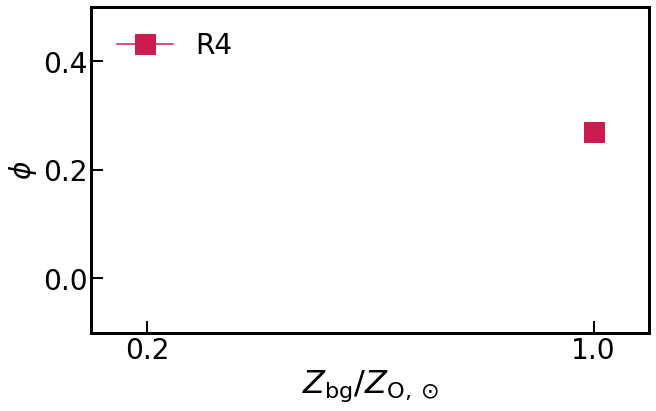

In [6]:
markersize = 10
lw=2.0

sigma_sfr = [6.e-5/yr_to_sec , 6.e-5/yr_to_sec , \
             0.000398107/yr_to_sec, 0.000398107/yr_to_sec, \
             1.58e-6/yr_to_sec, 1.58e-6/yr_to_sec]      


label = ['R8', '', 'R4', '', 'R16', '']
Zbg = [1., 0.2, 1.0, 0.2, 1.0, 0.2]
color =sns.color_palette("rocket",n_colors=3) 
clors = [color[0], color[0], color[1], color[1], color[2] , color[2]]
marker = ['s', '*', 's', '*', 's', '*' ]

plt.figure(figsize=(6,6))
f, ax = plt.subplots(1, 1, gridspec_kw = {'wspace':0.00, 'hspace':0.00},figsize=(10,6))


for i in [2]:
    
    Ztot = Zinj_avg[i] + 8.6e-3*Zbg[i] 
    
    Mz_bg = 8.6e-3*Zbg[i] * Mdot_avg[i]
    
    Mz_tot = Mz_avg[i] +  Mz_bg
    zeta = ( Mz_tot/Mdot_avg[i]/Ztot)
    phi=((Mz_tot-Mdot_avg[i]*Ztot)/(sigma_sfr[i]*Msun))
    

#     ax.plot(Zbg[i], zeta, 's', color=color[i], label=label[i], markersize=12)
#     ax.plot(Zbg[i], zeta, marker=marker[i], color=clors[i],  markersize=24, label=label[i])
    ax.plot(Zbg[i], phi, marker=marker[i], color=clors[i],  markersize=20, label=label[i])
    print(phi, zeta, Mz_tot, Mz_tot/(sigma_sfr[i]*Msun), (Mdot_avg[i]*Ztot) )
    
ax.legend(frameon=False, loc='upper left', ncol=3)
ax.set_ylabel(r'$\phi$')
ax.set_xlabel(r'$Z_{\rm bg}/Z_\mathrm{O,\odot}$', fontsize=32)
ax.set_ylim(-0.1, 0.5)
ax.set_xlim(0.1,1.1)
ax.set_xticks((0.2, 1.0))
# plt.savefig(fig_path + '/phi.jpeg', bbox_inches='tight')

In [ ]:
fig_path + '/phi.jpeg'

In [ ]:
kk = 0 
sigma_sfr = [6.e-5/yr_to_sec , 0.000398107/yr_to_sec]  
folder_list = ['GasGravity/'] 

for folder in folder_list:
    data_path = os.path.join(h5_path, 'sims/', folder, 'PhaseOutflowRates/')
    print(data_path)
    os.chdir(data_path)
    list_file = glob.glob("phase_outflow_*.h5")
    
    dom_min, dom_max, ncells = getdomain(infile)
    fac = 1
    zrange = np.linspace(dom_min[2], dom_max[2], (fac*int(ncells[2])))
    xrange = np.linspace(dom_min[0], dom_max[0], (fac*int(ncells[0])))
    yrange = np.linspace(dom_min[1], dom_max[1], (fac*int(ncells[1])))

    dx = (dom_max[0]- dom_min[0])/(fac*int(ncells[0]))
    
    
    timestep = np.zeros((len(list_file)))
    tot_mass_flux = np.zeros((len(list_file), zrange.shape[0]))
    tot_scalar_flux = np.zeros((len(list_file), zrange.shape[0]))
    tot_scalar = np.zeros((len(list_file), zrange.shape[0]))
    tot_rho = np.zeros((len(list_file), zrange.shape[0]))
    
    i = 0 
    for f in list_file:
        inputfile = os.path.join(data_path, f)
        
        hf = h5py.File(inputfile, 'r') 
        timestep[i] = np.array(hf.get("Timestep"))
        
        tot_mass_flux[i]   = np.array(hf.get("TotalOutflowRate"))
        tot_scalar_flux[i] = np.array(hf.get("TotalMetOutflowRate"))
        tot_scalar[i]      = np.array(hf.get("TotalScalarValue"))
        tot_rho[i]         = np.array(hf.get("TotalMass"))
            
        i+=1
        
    
    
    flux_sum      = np.sum(tot_mass_flux[:,index-3:index+2], axis=1)/5
    scal_flux_sum = np.sum(tot_scalar_flux[:,index-3:index+2], axis=1)/5

    scal_sum      = np.sum(tot_scalar[:,vol_index], axis=1)*Msun/1.e3
    rho_sum       = np.sum(tot_rho[:,vol_index], axis=1)
    
    
    time_mask = timestep>50.
    
    mass_flux_time_averaged = np.average(flux_sum)
    scal_flux_time_averaged = np.average(scal_flux_sum)
    
    scal_sum_time_averaged  = np.average(scal_sum)
    rho_sum_time_averaged   = np.average(rho_sum)
    
    Zinj_avg[kk] = scal_sum_time_averaged / rho_sum_time_averaged 
    Mz_avg[kk]   = scal_flux_time_averaged
    Mdot_avg[kk] = mass_flux_time_averaged
    

    zeta = scal_flux_time_averaged/mass_flux_time_averaged/Zinj_avg[kk]
    phi = (scal_flux_time_averaged - mass_flux_time_averaged*Zinj_avg[kk])/sigma_sfr[kk]/Msun
    print(scal_sum_time_averaged,rho_sum_time_averaged  )
    kk+=1

In [ ]:
Zbg = np.linspace(0.0, 2.0, 20)
markersize = 10
lw=2.0

sigma_sfr = [6.e-5/yr_to_sec , 0.000398107/yr_to_sec]      


label = ['R8', 'R4']

color =sns.color_palette("rocket",n_colors=2) 
plt.figure(figsize=(6,6))
f, ax = plt.subplots(1, 1, gridspec_kw = {'wspace':0.00, 'hspace':0.00},figsize=(10,8))

for i in range(1):
    
    Ztot = Zinj_avg[i] + 8.6e-3*Zbg 
    
    
    zeta = Mz_avg[i]/Mdot_avg[i]/Ztot
    phi = (Mz_avg[i]-Mdot_avg[i]*Ztot)/(sigma_sfr[i]*Msun)
    
    ax.plot(Zbg, zeta, 's', ls='-', lw=lw, color=color[i], markersize=markersize, label=label[i])
    ax.plot(Zbg, phi, 'v', ls='-', lw=lw, color=color[i], markersize=markersize)
    
    
ax.legend()
ax.set_ylabel(r'$\zeta$')
ax.set_xlabel(r'$Z_{\rm bg}/Z_\mathrm{O,\odot}$', fontsize=32)
ax.set_ylim(-3., 5.)

In [ ]:
kk = 0 
sigma_sfr = [6.e-5/yr_to_sec , 0.000398107/yr_to_sec]  
folder_list = ['GasGravity/'] 

for folder in folder_list:
    data_path = os.path.join(h5_path, 'sims/', folder, 'PhaseOutflowRates/')
    print(data_path)
    os.chdir(data_path)
    list_file = glob.glob("phase_totoutflow_*.h5")
    print(len(list_file))
    dom_min, dom_max, ncells = getdomain(infile)
    fac = 1
    zrange = np.linspace(dom_min[2], dom_max[2], (fac*int(ncells[2])))
    xrange = np.linspace(dom_min[0], dom_max[0], (fac*int(ncells[0])))
    yrange = np.linspace(dom_min[1], dom_max[1], (fac*int(ncells[1])))

    dx = (dom_max[0]- dom_min[0])/(fac*int(ncells[0]))
    
    
    timestep = np.zeros((len(list_file)))
    tot_mass_flux = np.zeros((len(list_file), zrange.shape[0]))
    tot_scalar_flux = np.zeros((len(list_file), zrange.shape[0]))
    tot_scalar = np.zeros((len(list_file), zrange.shape[0]))
    tot_rho = np.zeros((len(list_file), zrange.shape[0]))
    
    i = 0 
    for f in list_file:
        inputfile = os.path.join(data_path, f)
        
        hf = h5py.File(inputfile, 'r') 
        timestep[i] = np.array(hf.get("Timestep"))
        
        tot_mass_flux[i]   = np.array(hf.get("TotalOutflowRate"))
        tot_scalar_flux[i] = np.array(hf.get("TotalMetOutflowRate"))
        tot_scalar[i]      = np.array(hf.get("TotalScalarValue"))
        tot_rho[i]         = np.array(hf.get("TotalMass"))
        
        i+=1
        
    
    
    flux_sum      = np.average(tot_mass_flux[:,index-3:index+2], axis=1)
    scal_flux_sum = np.average(tot_scalar_flux[:,index-3:index+2], axis=1)

    
    scal_sum      = np.sum(tot_scalar[:,vol_index], axis=1)*Msun/1.e3
    rho_sum       = np.sum(tot_rho[:,vol_index], axis=1)

    
    time_mask = timestep>50.
    
    mass_flux_time_averaged = np.average(flux_sum)
    scal_flux_time_averaged = np.average(scal_flux_sum)
    
    scal_sum_time_averaged  = np.average(scal_sum)
    rho_sum_time_averaged   = np.average(rho_sum)
    
    Zinj_avg[kk] = scal_sum_time_averaged / rho_sum_time_averaged 
    Mz_avg[kk]   = scal_flux_time_averaged
    Mdot_avg[kk] = mass_flux_time_averaged
    

    zeta = scal_flux_time_averaged/mass_flux_time_averaged/Zinj_avg[kk]
    phi = (scal_flux_time_averaged - mass_flux_time_averaged*Zinj_avg[kk])/sigma_sfr[kk]/Msun
    print(zeta,phi)
    kk+=1

In [ ]:
Mdot_avg, Mz_avg, Zinj_avg, zeta

In [ ]:
Zbg = np.linspace(0.0, 2.0, 20)
markersize = 10
lw=2.0

sigma_sfr = [6.e-5/yr_to_sec , 0.000398107/yr_to_sec]      


label = ['R8', 'R4']

color =sns.color_palette("rocket",n_colors=2) 
plt.figure(figsize=(6,6))
f, ax = plt.subplots(1, 1, gridspec_kw = {'wspace':0.00, 'hspace':0.00},figsize=(10,8))

for i in range(1):
    
    Ztot = Zinj_avg[i] + 8.6e-3*Zbg 
    print(Zbg_avg[i])
    
    zeta = Mz_avg[i]/Mdot_avg[i]/Ztot
    phi = (Mz_avg[i]-Mdot_avg[i]*Ztot)/(sigma_sfr[i]*Msun)
    
    ax.plot(Zbg, zeta, 's', ls='-', lw=lw, color=color[i], markersize=markersize, label=label[i])
    ax.plot(Zbg, phi, 'v', ls='-', lw=lw, color=color[i], markersize=markersize)
    
    
ax.legend()
# ax.set_yscale('log')
ax.set_ylabel(r'$\zeta$')
ax.set_xlabel(r'$Z_{\rm bg}/Z_\mathrm{O,\odot}$', fontsize=32)
ax.set_ylim(-3., 5.)